# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
from data_transformation import CleanData
from features_library import FeatureTransformations
from regression import (
                        BaseReg,
                        RandomForestReg, 
                        HistGradientBoostingReg, 
                        SGDReg, 
                        ElasticNetReg, 
                        TheilSenReg,
                        RANSACReg
                        )
from trading_strategies import TradingStrategy
from performance_metrics import PerformanceMetrics

In [30]:
np.random.seed(2)

# Load Data

In [4]:
DIR_CRYPTO_DATA = "./data/1_Crypto_data/"
DIR_FINANCIAL_DATA = "./data/1_Financial_component_data/"

In [5]:
dict_assets = {}
ASSETS_SELECTED = [
    'BTC-USD',
    'ETH-USD',
    'XRP-USD',
    'LTC-USD',
]

for file_crypto in glob(f"{DIR_CRYPTO_DATA}*.csv"):

    # Read CSV
    asset_name = os.path.basename(file_crypto).split(".")[0]
    if not asset_name in ASSETS_SELECTED:
        continue
    df_asset = pd.read_csv(file_crypto)

    # Pre-Process Data
    preproc = CleanData(df_asset)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # assign to dict
    dict_assets[asset_name] = preproc.df


In [6]:
dict_fd = {}
for file_fd in glob(f"{DIR_FINANCIAL_DATA}*.csv"):

    # Read CSV
    fd_name = os.path.basename(file_fd).split(".")[0]
    df_fd = pd.read_csv(file_fd)

    if fd_name.startswith("F-F"):
        df_fd = df_fd.loc[df_fd['Date']>19700101]
        df_fd["Date"] = df_fd["Date"].astype(str)
        df_fd["Date"] = df_fd["Date"].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

    # Pre-Process Data
    preproc = CleanData(df_fd)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()
    preproc.ffill()

    # Keep??
    # if ('Adj Close' not in df_fd.columns) and ('Close' in df_fd.columns):
    #     df_fd['Adj Close'] = df_fd['Close'].copy()

    # assign to dict
    dict_fd[fd_name] = preproc.df

In [7]:
df_risk_free = pd.read_excel(os.path.join(DIR_FINANCIAL_DATA, "RiskFree.xls"))
df_risk_free.index = df_risk_free['TcmDate']
df_risk_free.index.name = None
df_risk_free = df_risk_free[['Tcm1mo', 'Tcm3mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr']]
df_risk_free = df_risk_free.resample('1D').first().ffill()
df_risk_free

Tcm1mo  Tcm3mo  Tcm1yr  Tcm5yr  Tcm10yr
1997-01-02  0.0519  0.0519  0.0563  0.0630   0.0654
1997-01-03  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-04  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-05  0.0517  0.0517  0.0560  0.0628   0.0652
1997-01-06  0.0517  0.0517  0.0561  0.0630   0.0654
...            ...     ...     ...     ...      ...
2023-03-16  0.0422  0.0474  0.0449  0.0372   0.0356
2023-03-17  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-18  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-19  0.0431  0.0452  0.0426  0.0344   0.0339
2023-03-20  0.0434  0.0481  0.0434  0.0356   0.0347

[9574 rows x 5 columns]

# Feature Engineering

## Make Feature Transformations

For Assets, apply all feature transformations

In [8]:
for asset in dict_assets:
    feature_transformer = FeatureTransformations(dict_assets[asset])
    feature_transformer.transform_assets()
    dict_assets[asset] = feature_transformer.df_asset

For S&P500, apply selected feature transformations

In [9]:
dict_fd['S_P 500 index']['Volume'] = np.nan
# dict_fd['S_P 500 index'] = dict_fd['S_P 500 index'].ffill()
feature_transformer = FeatureTransformations(dict_fd['S_P 500 index'])
feature_transformer.transform_snp500()
dict_fd['S_P 500 index'] = feature_transformer.df_asset
dict_fd['S_P 500 index'].drop(columns=['Volume'], inplace=True)

## Add Financial Data to assets

In [10]:
for asset_name, df_asset in dict_assets.items():
    
    ASSET_START_PERIOD = df_asset.index.min()
    ASSET_END_PERIOD = df_asset.index.max()

    for financial_dataset, df_fd in dict_fd.items():

        df_fd = df_fd[ASSET_START_PERIOD:ASSET_END_PERIOD]
        
        rename_fd_cols = {column: f"{financial_dataset}_{column}".replace(" ", "_") for column in df_fd.columns}
        df_fd.rename(columns=rename_fd_cols, inplace=True)
        df_asset = pd.concat([df_asset, df_fd], axis=1)
    
    # add risk-free info
    df_asset = pd.concat([df_asset, df_risk_free[ASSET_START_PERIOD:ASSET_END_PERIOD]], axis=1)
    
    dict_assets[asset_name] = df_asset

## Normalize Features

In [11]:
# for asset_name, df_asset in dict_assets.items():
#     scaler = StandardScaler()
#     df_asset[df_asset.columns] = scaler.fit_transform(df_asset)
#     dict_assets[asset_name] = df_asset

# EDA Plots

## Describe Price Movements

Plot of close price trends with high-low indicators

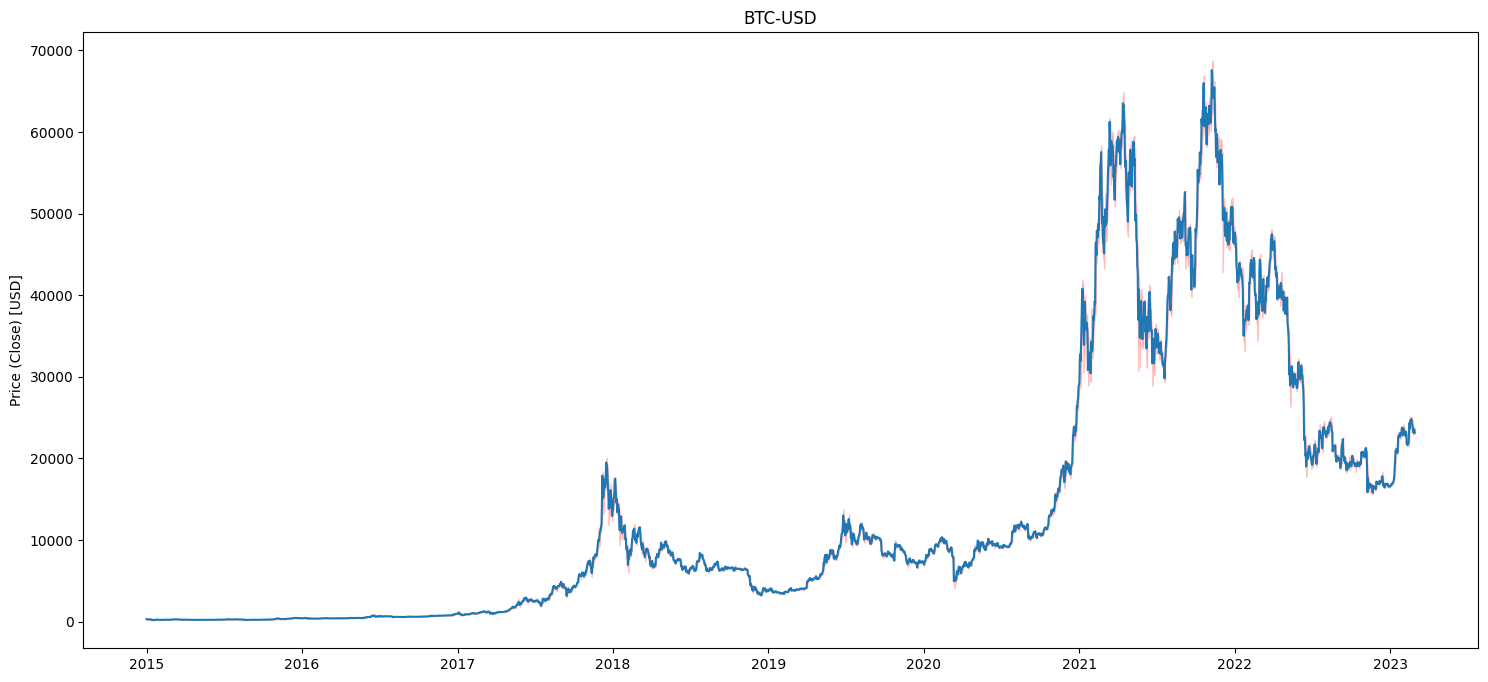

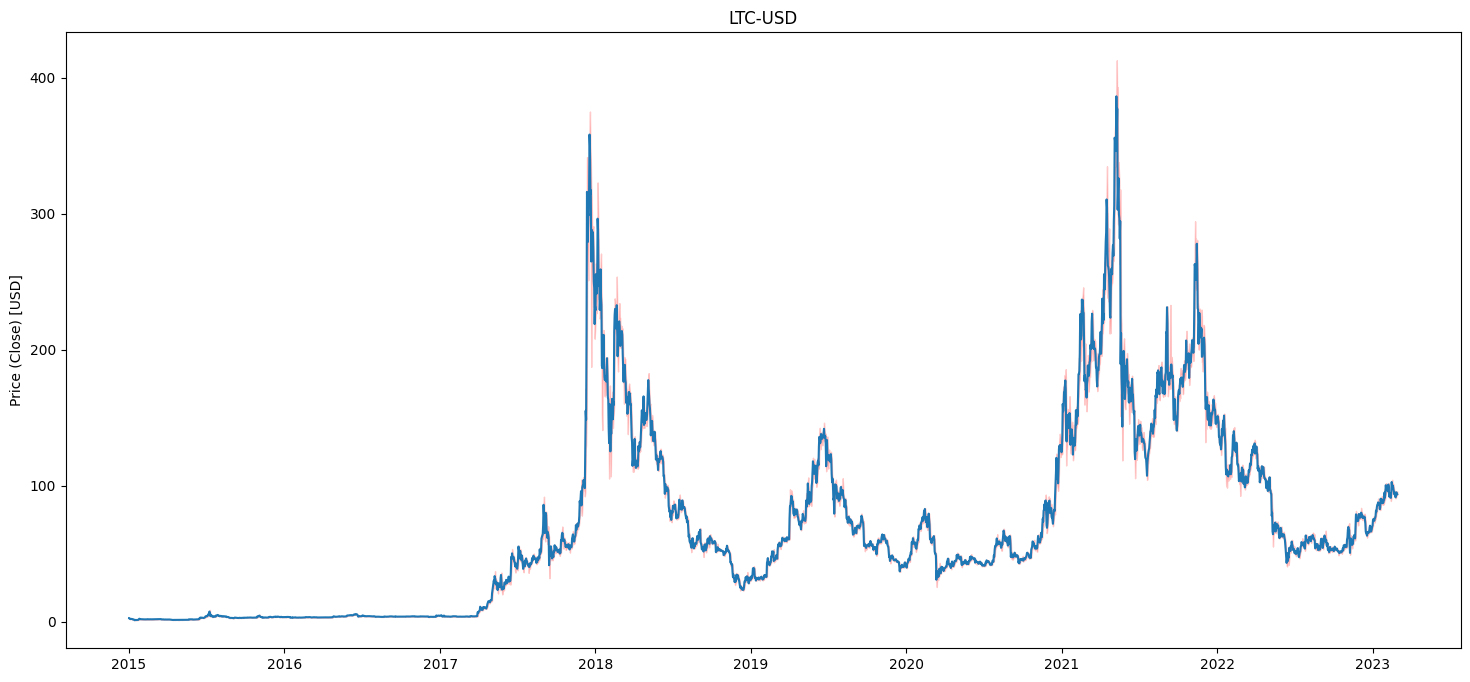

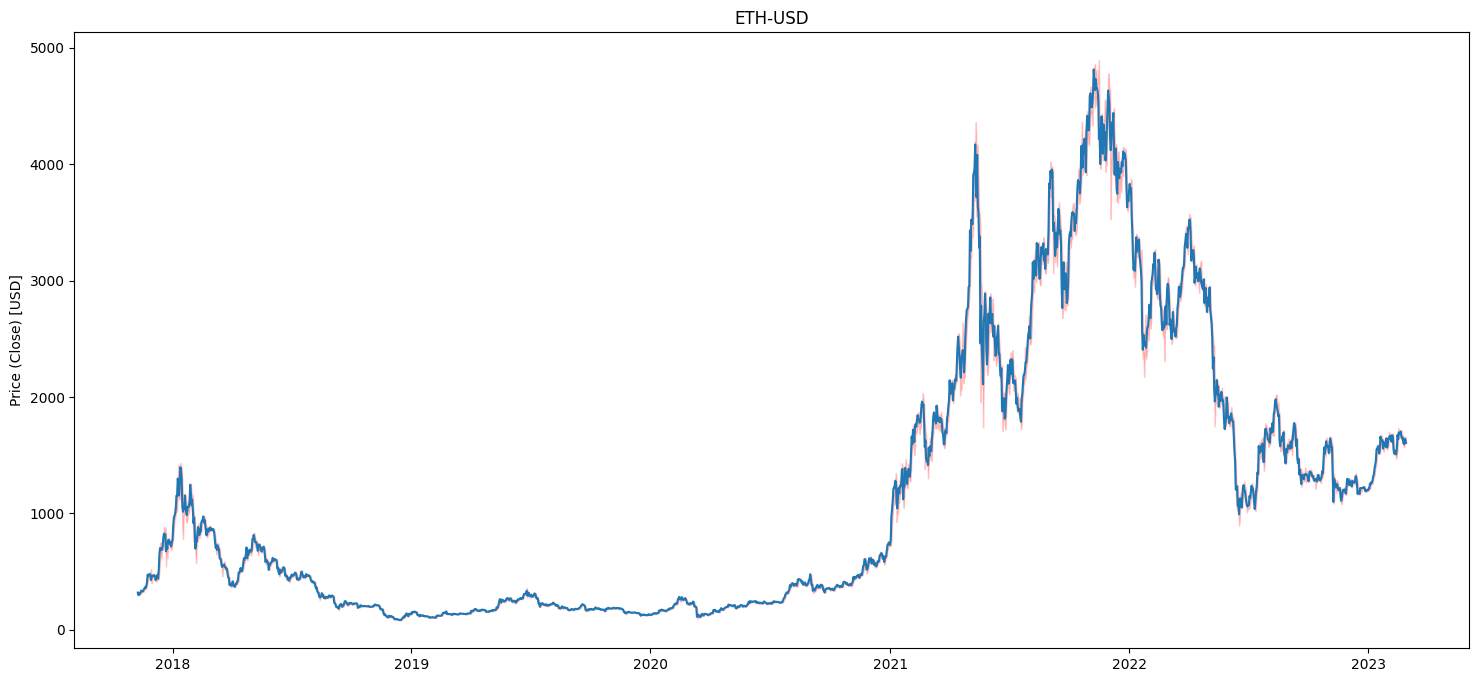

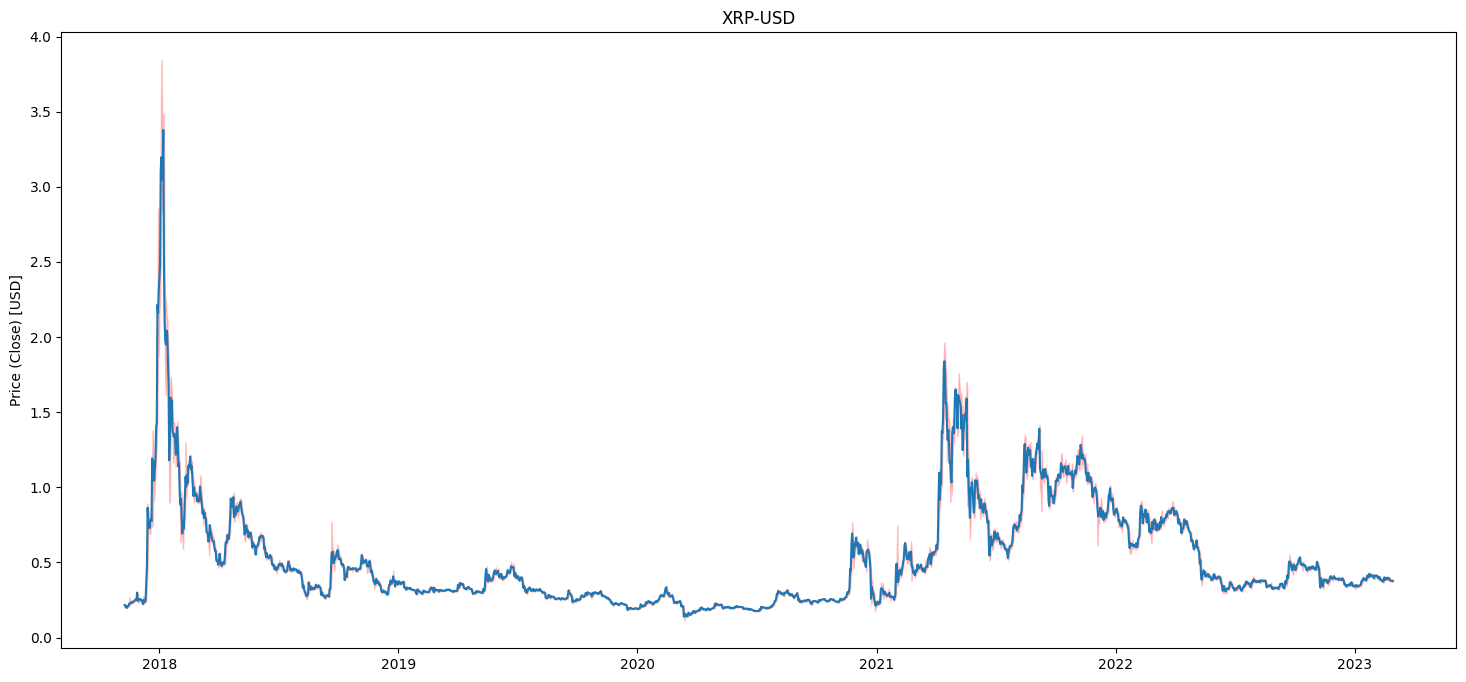

In [ ]:
nrows = len(df_asset)
ncols = 1


for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 8))
    df_plot = df_asset#['2022-01-01': '2022-06-30']
    ax.plot(df_plot['Close'])

    ax.fill_between(
        df_plot.index, 
        df_plot['High'], 
        df_plot['Low'], 
        alpha=0.2,
        color='red',
        interpolate=False,
        )
    ax.set_title(asset_name)
    ax.set_ylabel("Price (Close) [USD]")
    
    plt.show()

Plot of close price trends of all assets

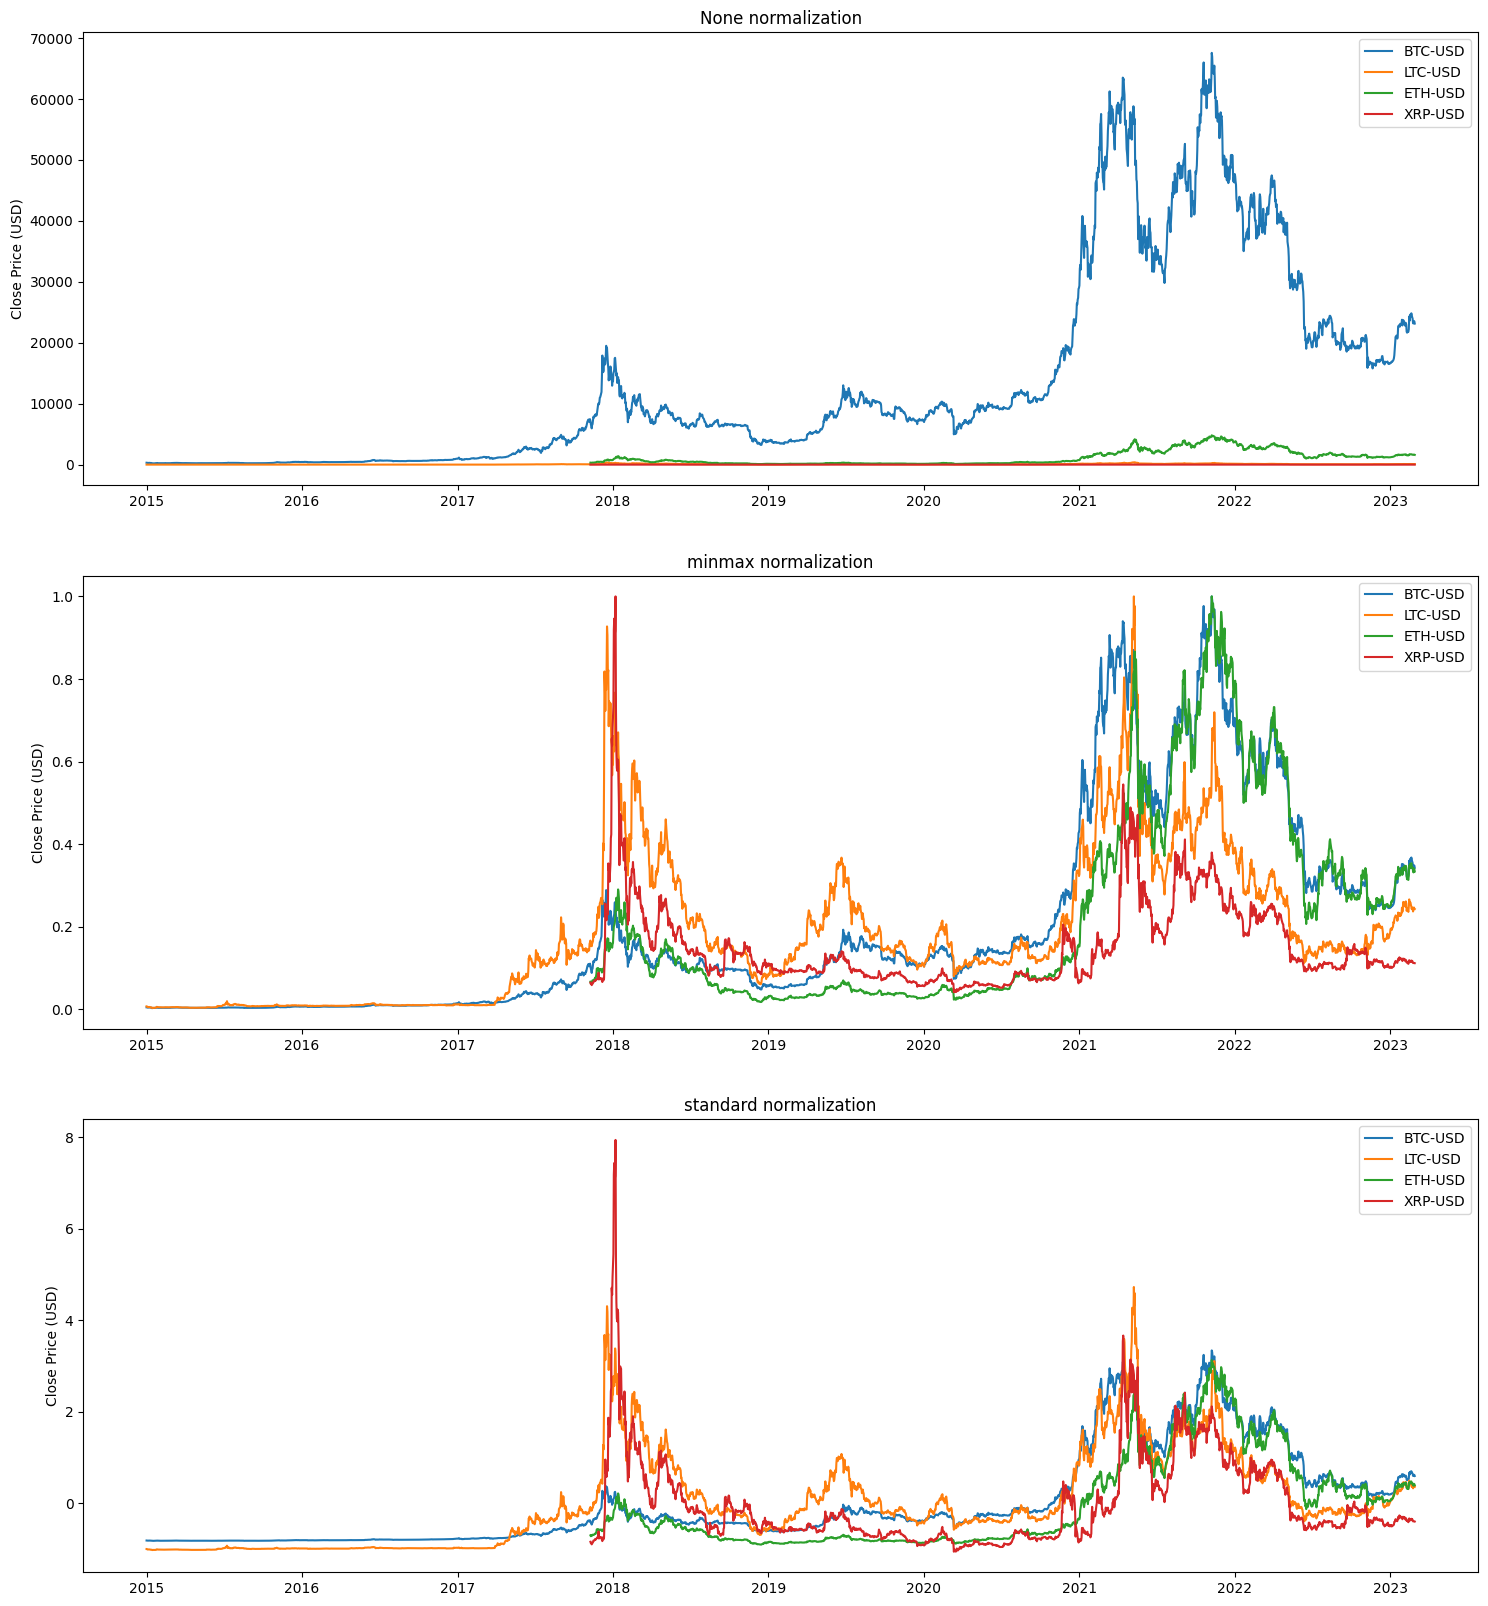

In [ ]:
NORM = [None, 'minmax', 'standard']

nrows, ncols = len(NORM), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    # if asset_name == 'BTC-USD':
    #     continue
    df_plot = df_asset # ['2021-01-01':]
    for idx, norm_method in enumerate(NORM):
        ax = axs[idx]
        if norm_method==None:
            ax.plot(df_plot['Close'], label=asset_name)
        
        elif norm_method=='minmax':
            ax.plot(df_plot['Close']/df_plot['Close'].max(), label=asset_name)
        elif norm_method=='standard':
            standard_scaler = StandardScaler()
            ax.plot(
                pd.Series(
                    standard_scaler.fit_transform(df_plot['Close'].values.reshape(-1, 1)).reshape(1,-1)[0],
                    index=df_plot['Close'].index
                    ), 
                    label=asset_name)
        ax.set_title(f"{str(norm_method)} normalization")
        ax.set_ylabel(f"Close Price (USD)")
        ax.legend()

plt.show()

## Describe Returns

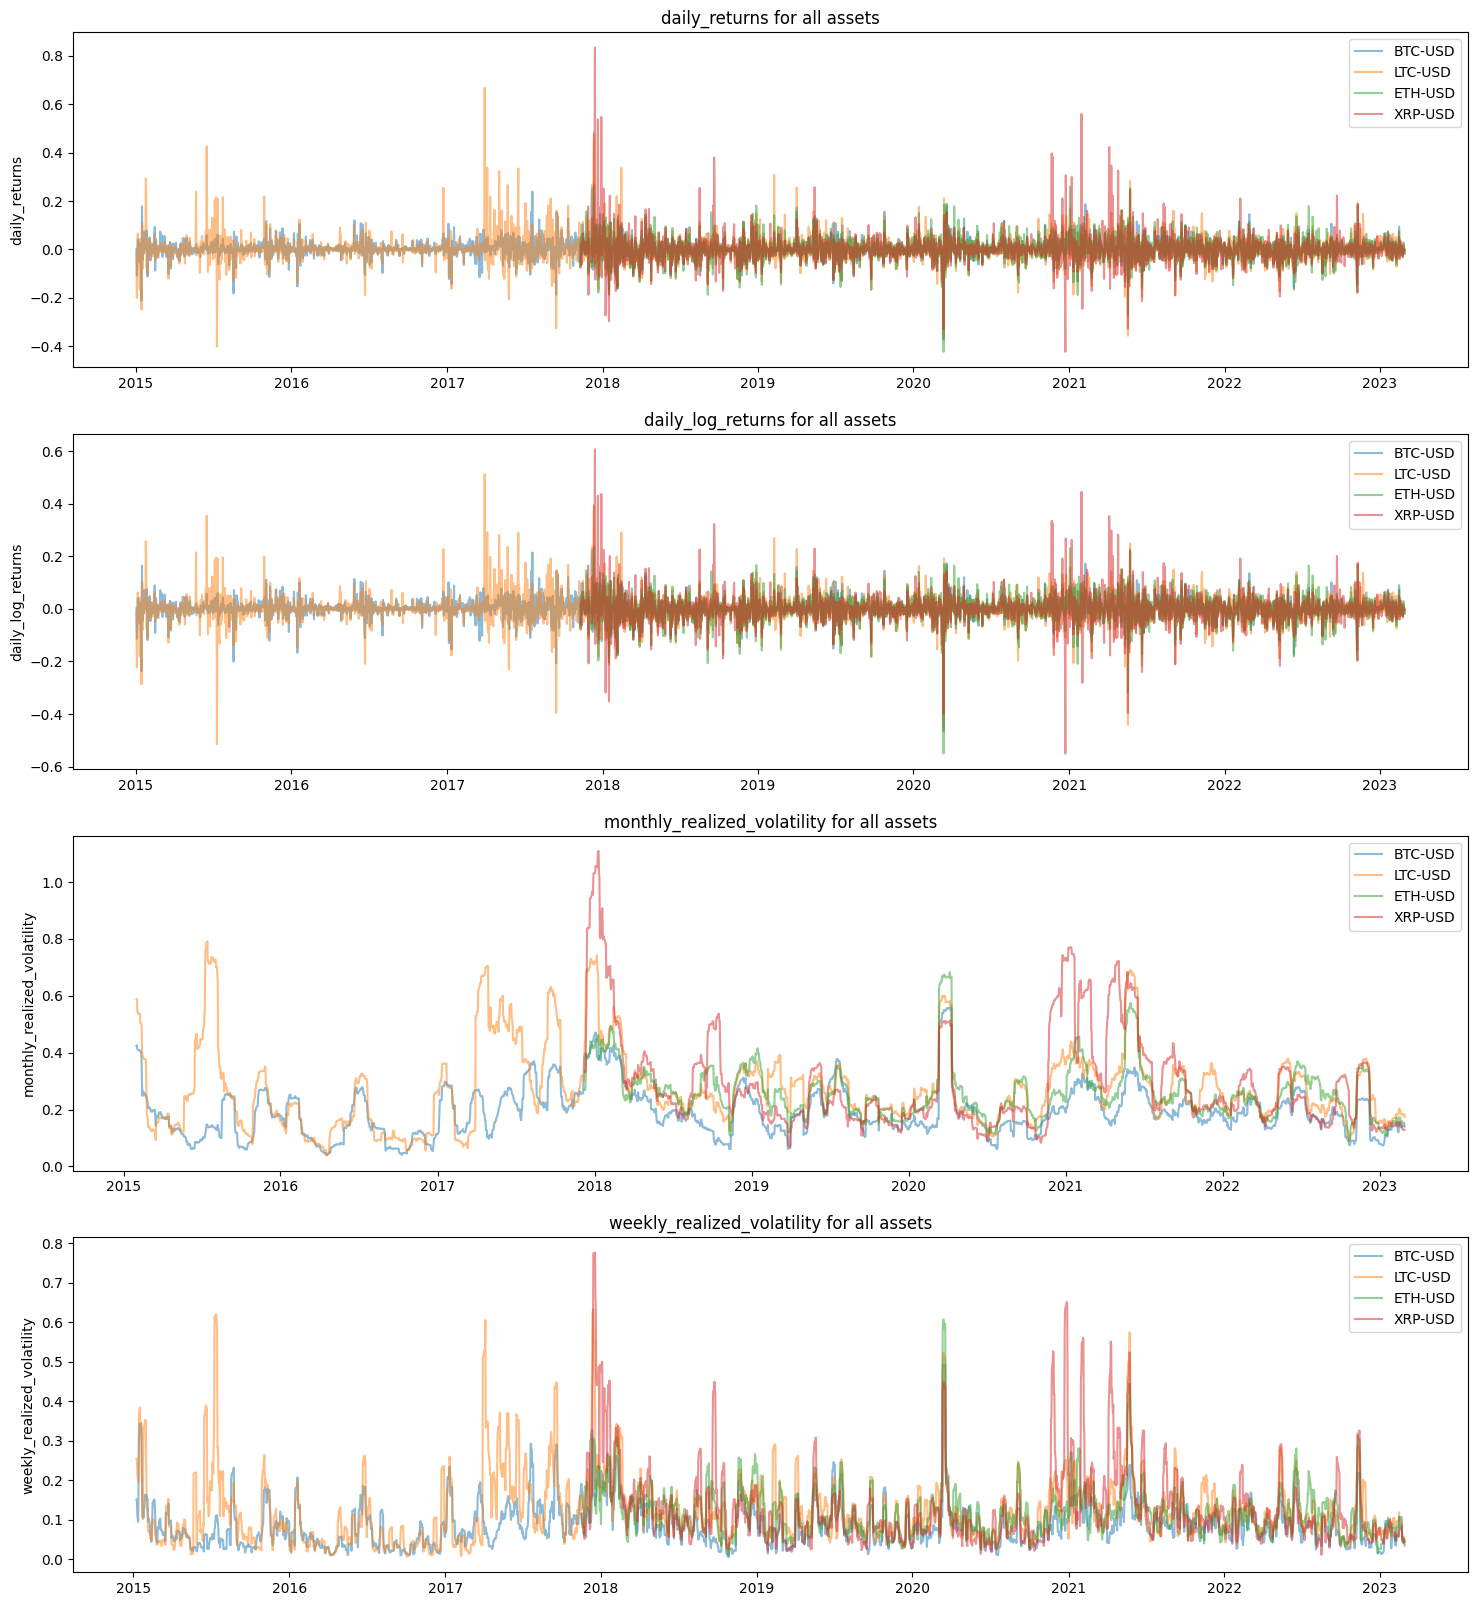

In [ ]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    for asset_name, df_asset in dict_assets.items():
        # if asset_name == 'BTC-USD':
        #     continue
        df_plot = df_asset#['2021-01-01':]
        ax.plot(df_plot[return_var], label=asset_name, alpha=0.5)
        
    ax.set_title(f"{str(return_var)} for all assets")
    ax.set_ylabel(str(return_var))
    ax.legend(loc='upper right')
    
plt.show()

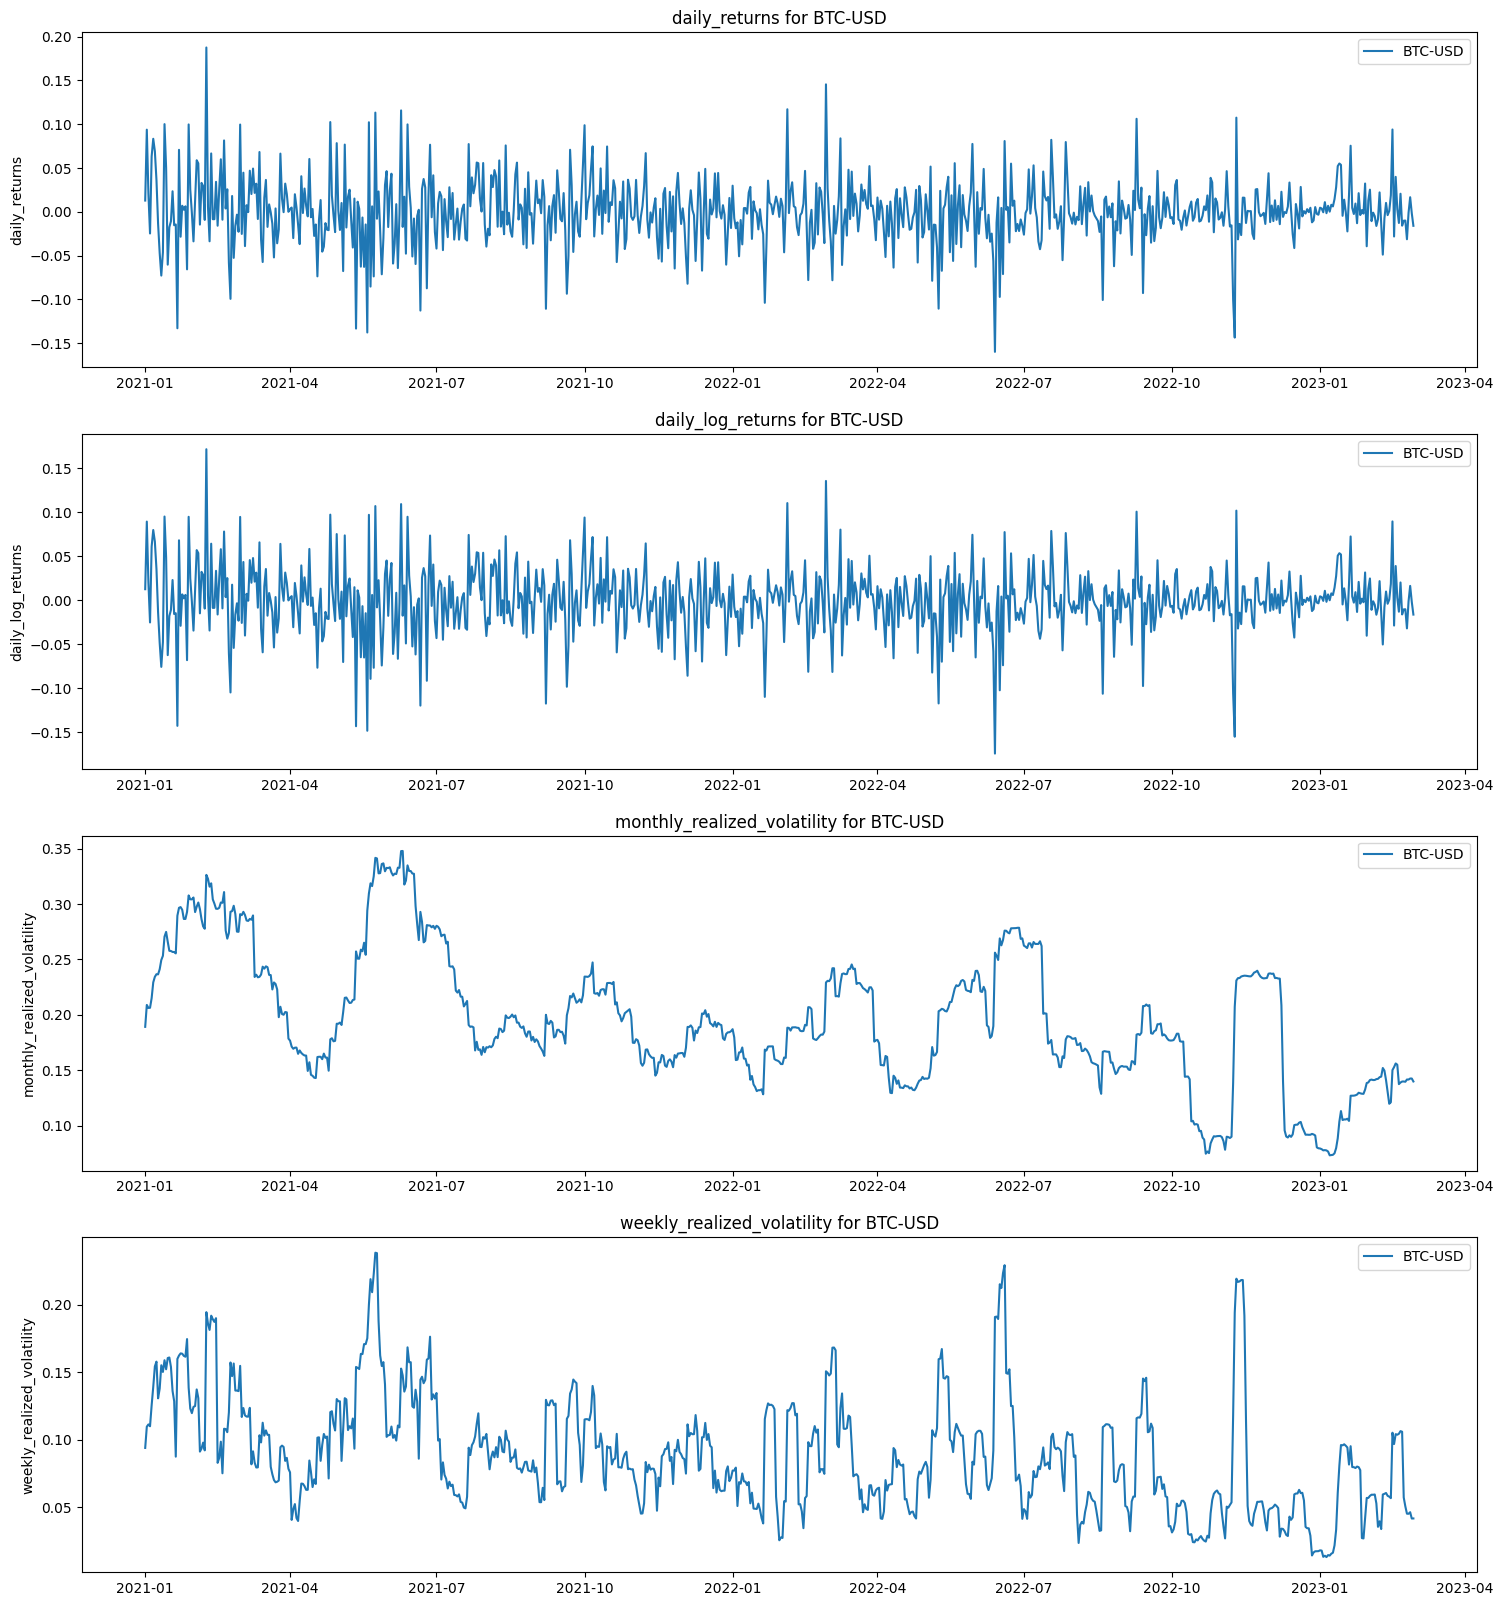

In [ ]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']
ASSET_NAME = 'BTC-USD'

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    df_asset = dict_assets[ASSET_NAME]
    df_plot = df_asset['2021-01-01':]
    ax.plot(df_plot[return_var], label=ASSET_NAME)

    ax.set_title(f"{str(return_var)} for {ASSET_NAME}")
    ax.set_ylabel(str(return_var))
    ax.legend()

plt.show()

## Correlation

Correlations between explanatory variables of each asset

In [ ]:
df_asset = dict_assets['BTC-USD']

<Axes: >

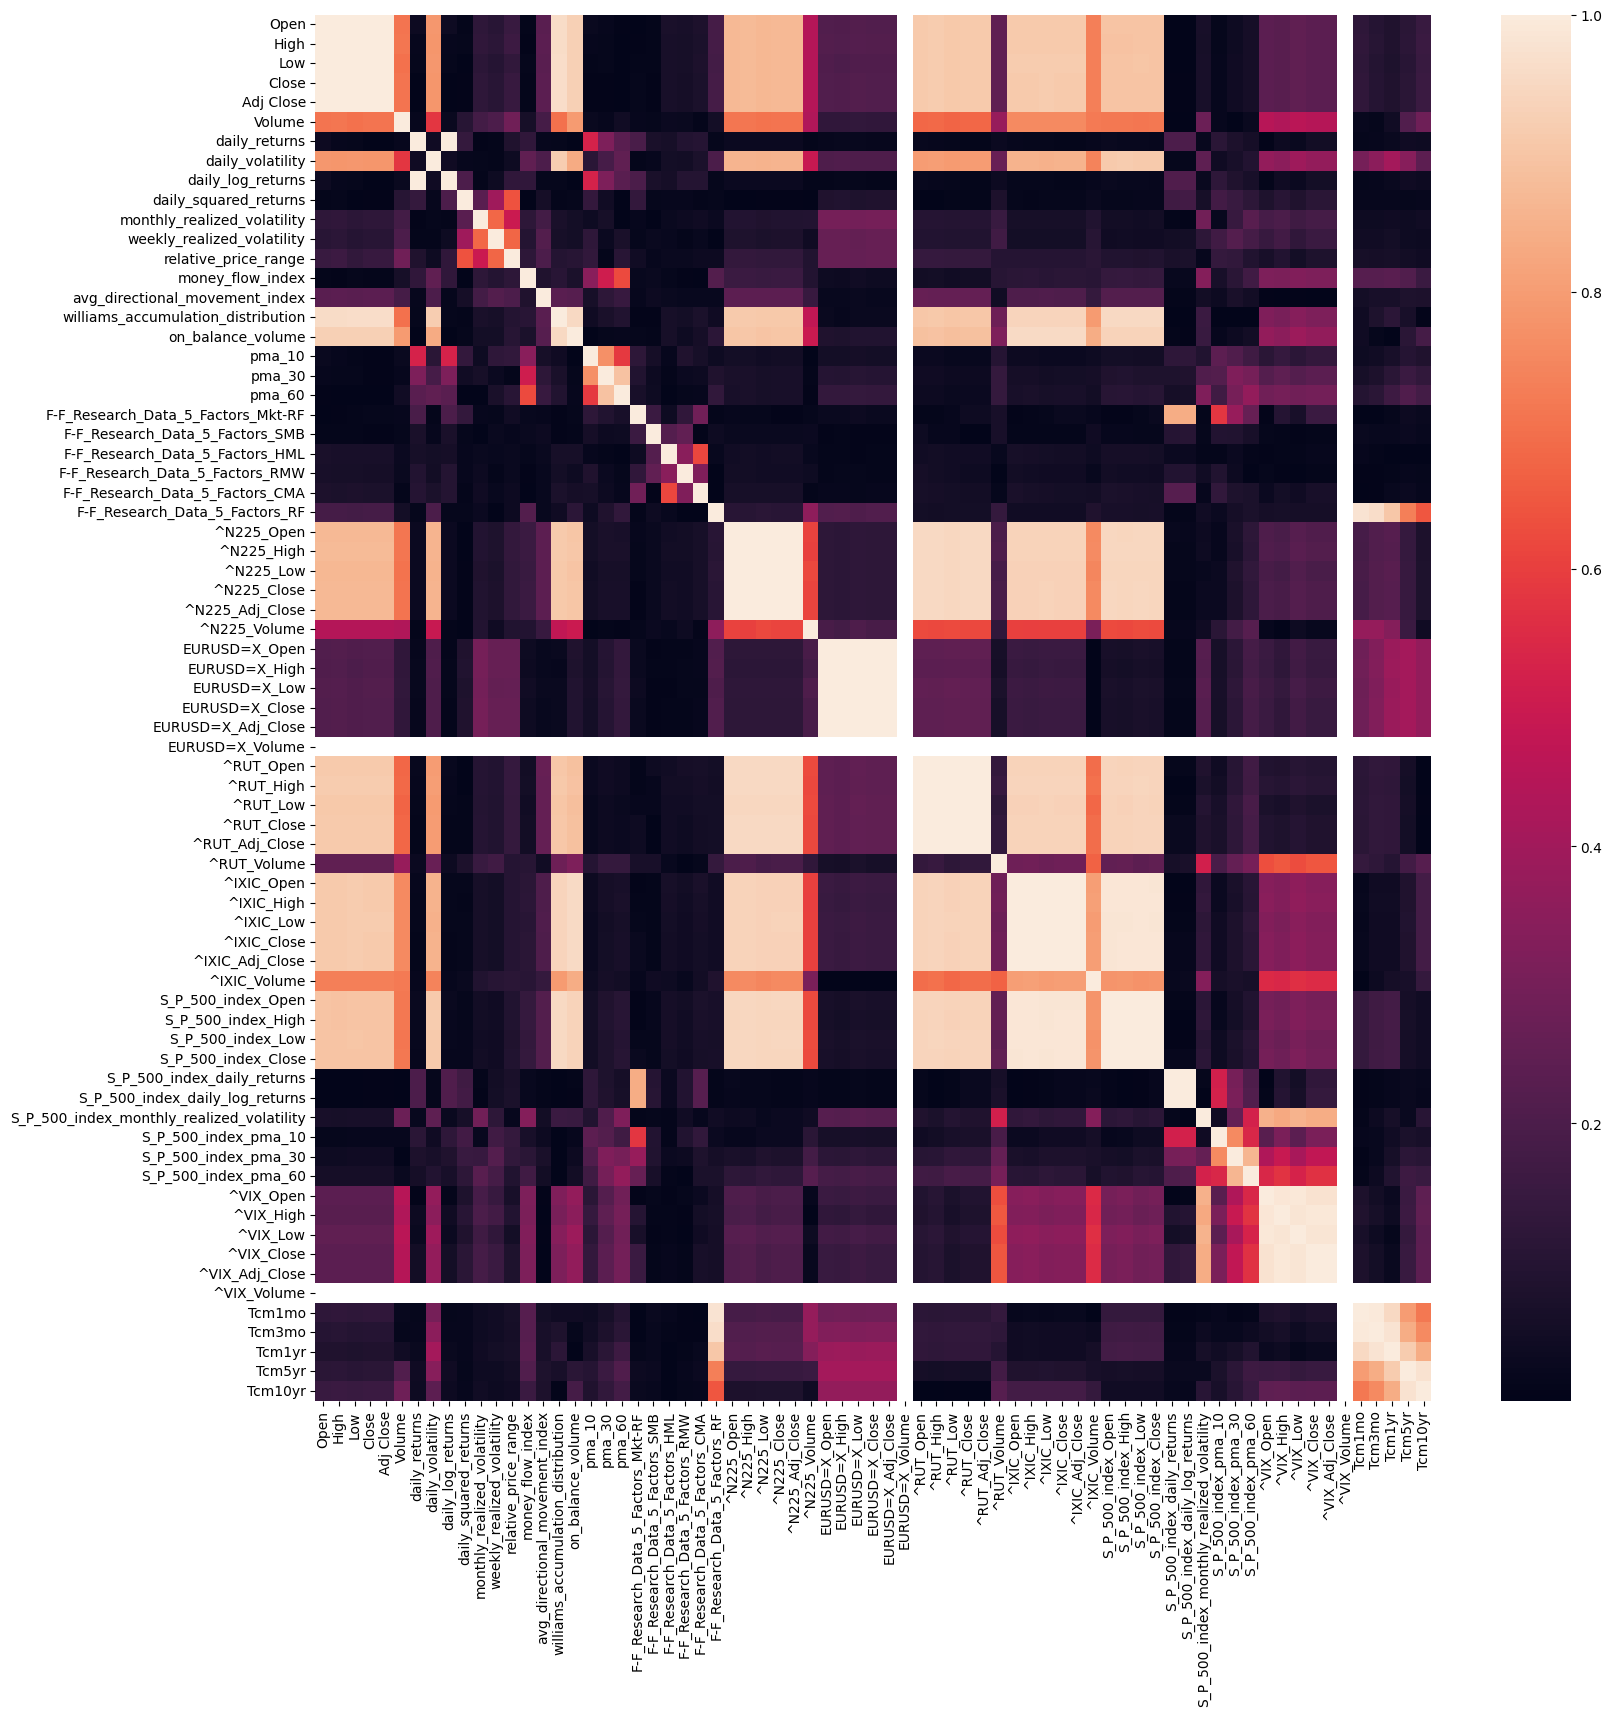

In [ ]:
#full time-frame from inception in 2015 onwards
df_asset_corr = abs(df_asset['2015-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

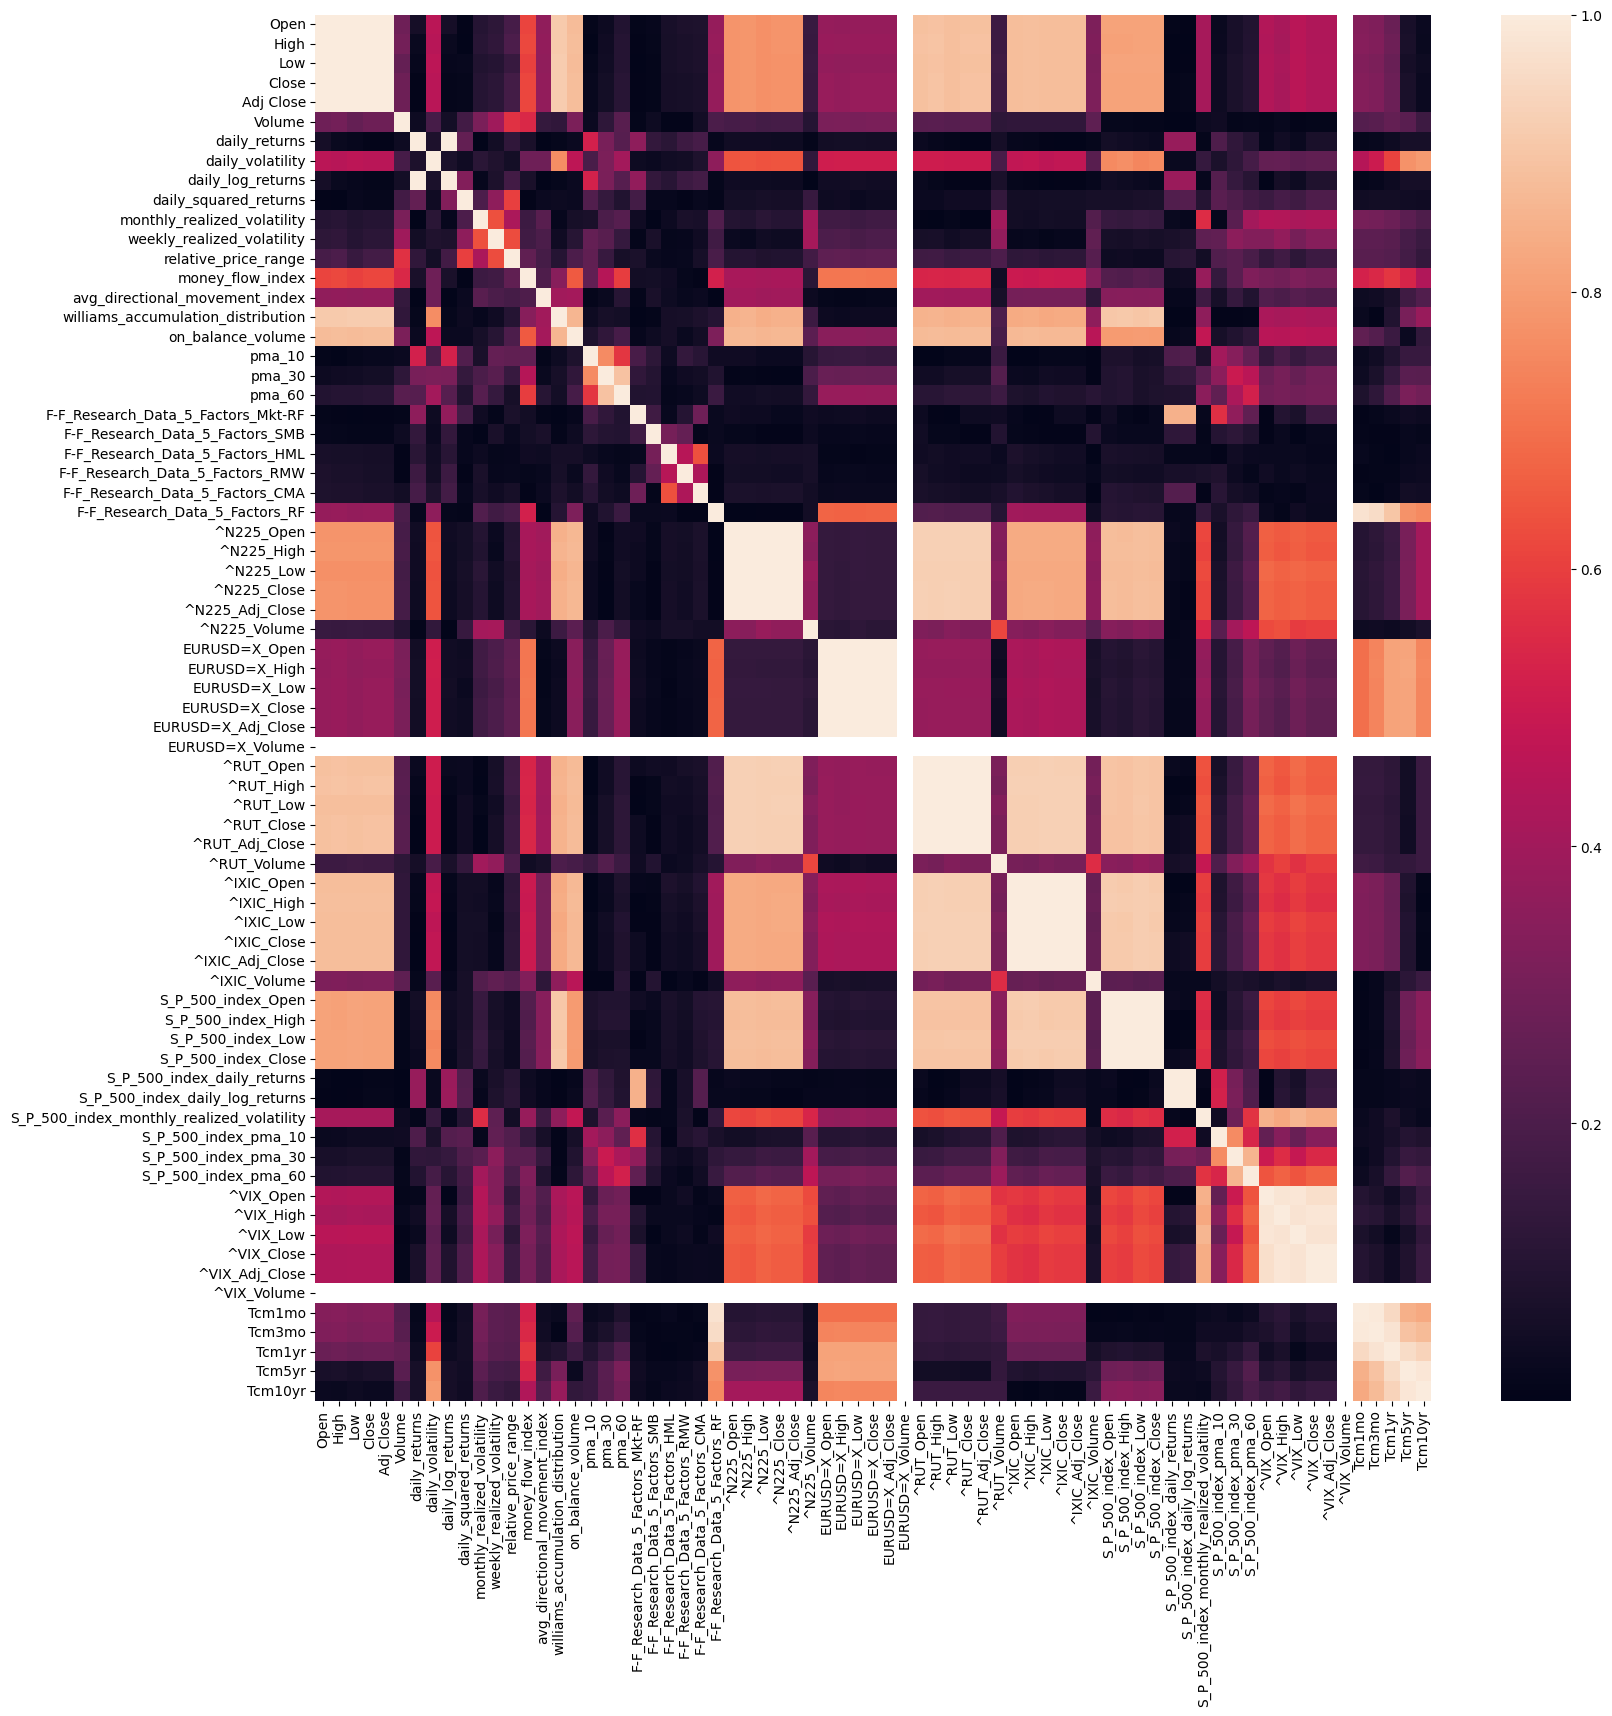

In [ ]:
#analysis time-frame 2020 onwards
df_asset_corr = abs(df_asset['2020-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

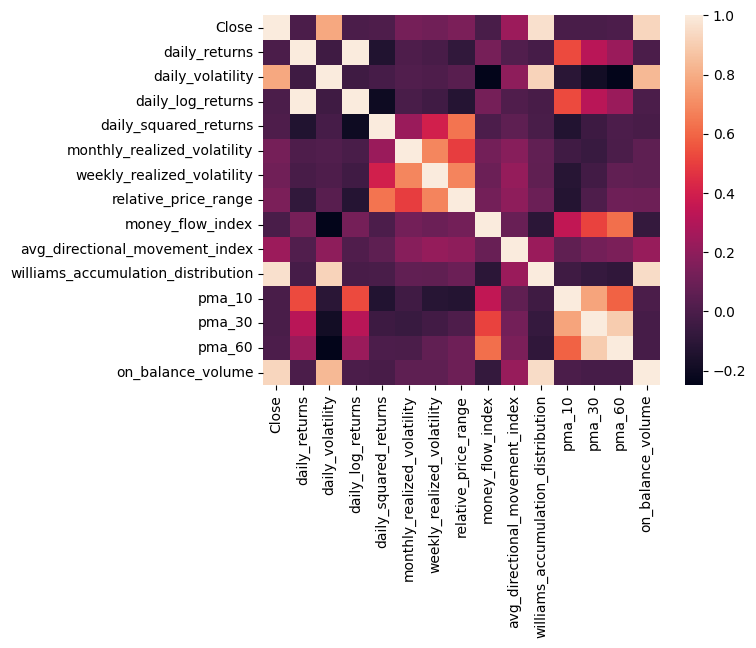

In [ ]:
CALC_FEATS = [
    'daily_returns','daily_volatility', 'daily_log_returns', 'daily_squared_returns',
    'monthly_realized_volatility', 'weekly_realized_volatility', 'relative_price_range', 
    'money_flow_index', 'avg_directional_movement_index', 'williams_accumulation_distribution',
    'pma_10', 'pma_30', 'pma_60', 'on_balance_volume'
    ]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

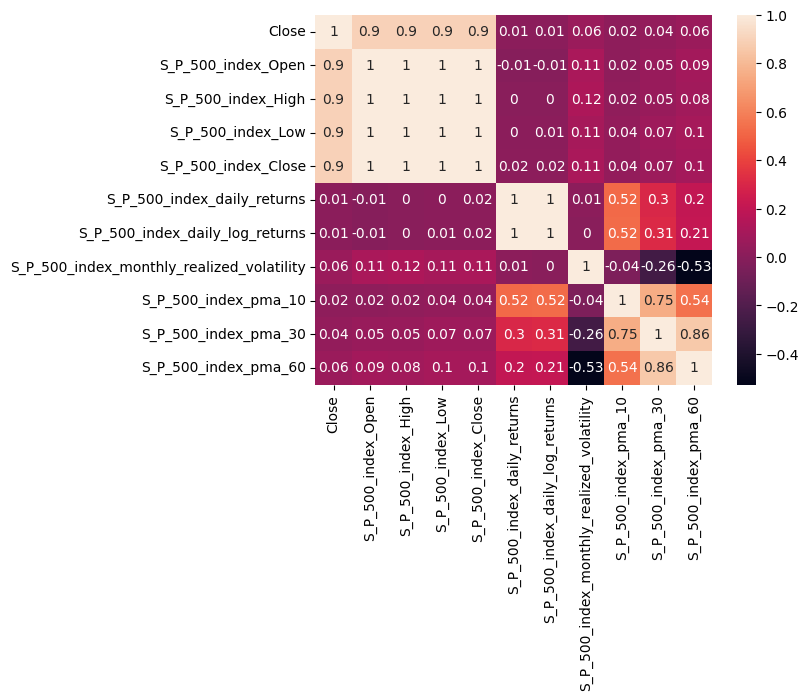

In [ ]:
CALC_FEATS = [col for col in df_asset.columns if 'S_P_500' in col]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    annot=np.round(df_asset_corr.values, 2),
)

<Axes: >

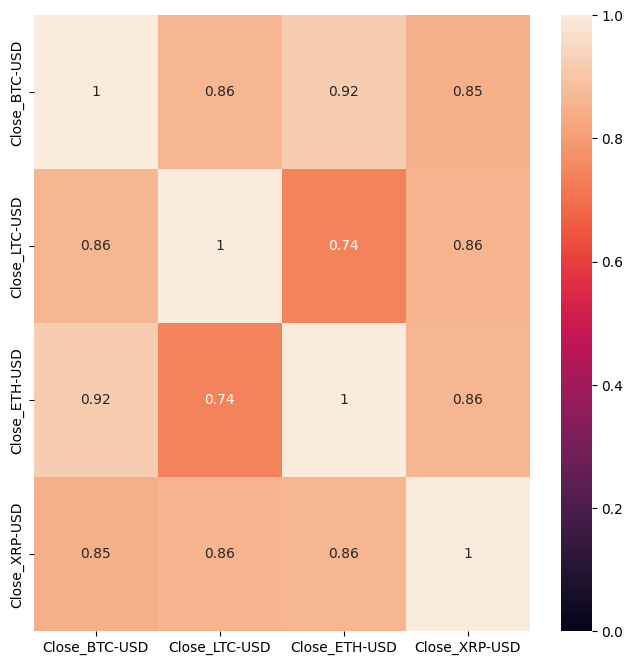

In [ ]:
#starting from 2019 because the assets became available since then
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2019-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

<Axes: >

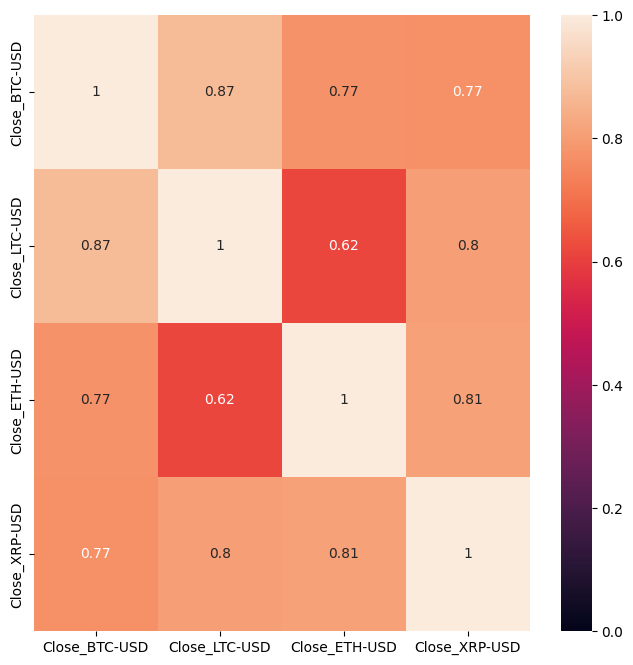

In [ ]:
#training period starts from 2021, so another view of correlations
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2021-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

In [ ]:
df_close_btc_eth = pd.concat(
    [
        dict_assets['BTC-USD']['Close'].rename("Close_BTC-USD"), 
        dict_assets['ETH-USD']['Close'].rename("Close_ETH-USD"), 
    ], 
    axis=1,
)
df_close_btc_eth = df_close_btc_eth.dropna()
df_close_btc_eth = df_close_btc_eth.resample('1D').first()

corr_btc_eth_mean = pearsonr(df_close_btc_eth['Close_BTC-USD'], df_close_btc_eth['Close_ETH-USD']).statistic
corr_btc_eth_60d_roll = df_close_btc_eth['Close_BTC-USD'].rolling('60D', min_periods=60).corr(df_close_btc_eth['Close_ETH-USD'])

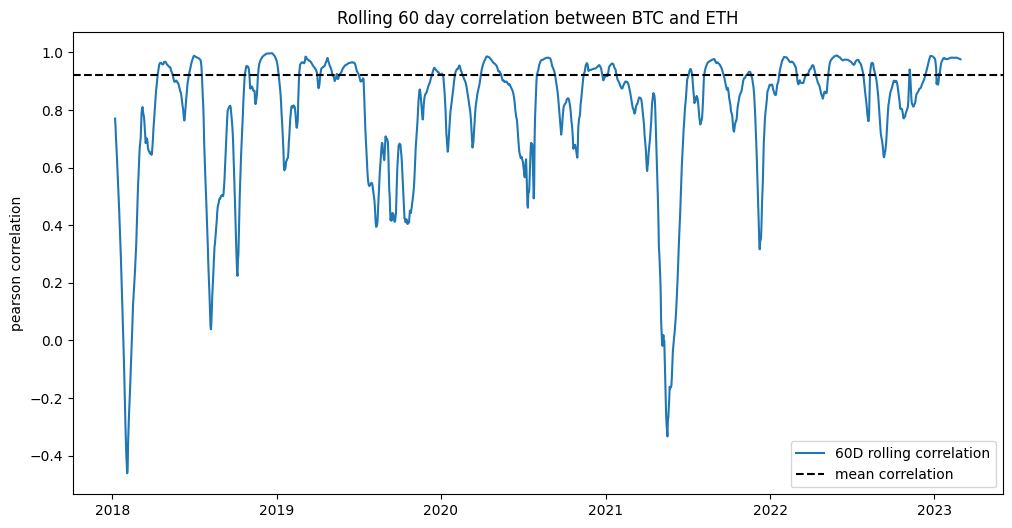

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(corr_btc_eth_60d_roll, label='60D rolling correlation')
plt.axhline(corr_btc_eth_mean, color='black', ls='--', label='mean correlation')

plt.title("Rolling 60 day correlation between BTC and ETH")
plt.ylabel("pearson correlation")
plt.legend()

## Descriptive Stats
N, min value, 1st quantile, median, mean, standard deviation, 3rd quantile, max value, skewness, kurtosis

In [ ]:
pd.options.display.max_columns = 100

In [ ]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)

df_descriptive_stats = pd.concat([
    df_close_all_assets.describe(), 
    pd.DataFrame(df_close_all_assets.kurtosis(), columns=['kurtosis']).T,
    pd.DataFrame(df_close_all_assets.skew(), columns=['skewness']).T,
])
df_descriptive_stats

Close_BTC-USD  Close_LTC-USD  Close_ETH-USD  Close_XRP-USD
count       2981.000000    2981.000000    1938.000000    1938.000000
mean       13481.524369      69.656052    1142.440624       0.520195
std        16181.118403      66.984527    1172.103874       0.359689
min          178.102997       1.157010      84.308296       0.139635
25%          920.382019       4.219910     213.643108       0.288724
50%         7556.237793      54.807610     559.634278       0.388867
75%        19044.107422     100.378006    1718.111817       0.656891
max        67566.828125     386.450775    4812.087402       3.377810
kurtosis       1.130637       1.653547       0.361284       9.853790
skewness       1.472561       1.291831       1.179694       2.419911

# Regression

In [35]:
df_asset = dict_assets['BTC-USD']
TARGET = 'daily_log_returns'

In [37]:
FEATURES_LIST_HAND_PICKED = [
    'Close', 'daily_volatility', 'Volume',
    'monthly_realized_volatility', 'weekly_realized_volatility',
    'relative_price_range', 'money_flow_index',
    'avg_directional_movement_index', 'williams_accumulation_distribution',
    'on_balance_volume', #'pma_10', 'pma_30', 'pma_60',
    
    'S_P_500_index_Close', 'S_P_500_index_pma_10', 'S_P_500_index_pma_30',
     'S_P_500_index_pma_60',
    'S_P_500_index_daily_log_returns',

    '^N225_Close', '^IXIC_Close', 'EURUSD=X_Close', '^VIX_Close', '^RUT_Close',

    'Tcm1mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr',

    'F-F_Research_Data_5_Factors_Mkt-RF', 
    #'F-F_Research_Data_5_Factors_SMB', 'F-F_Research_Data_5_Factors_HML', 'F-F_Research_Data_5_Factors_RMW',
    #'F-F_Research_Data_5_Factors_CMA', 'F-F_Research_Data_5_Factors_RF',

]

len(FEATURES_LIST_HAND_PICKED)

25

<Axes: >

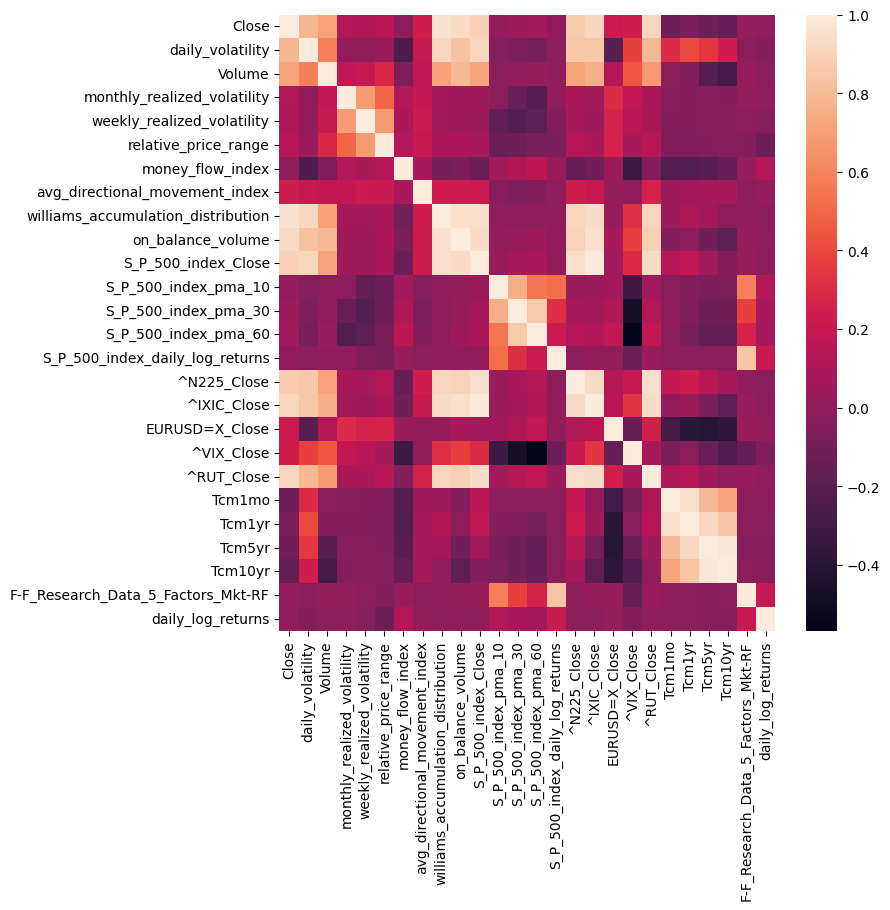

In [38]:
corr = df_asset[FEATURES_LIST_HAND_PICKED+[TARGET]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    # annot=corr.values,
    ax=plt.gca(),
    # vmin=0,
)

In [39]:
TRAIN_DATE_RANGE = ("2018-01-01", "2021-12-31")
TEST_DATE_RANGE = ("2022-01-01", "2022-12-31")
OOS_DATE_RANGE = ("2023-01-01", "2023-01-31")

In [40]:
def train_test_split(df_asset, TRAIN_DATE_RANGE, TEST_DATE_RANGE, OOS_DATE_RANGE, FEATURES_LIST, TARGET, norm=False):
    
    df_asset_tts = df_asset.copy()
    df_asset_tts[TARGET] = df_asset_tts[TARGET].shift(periods=-1)
    df_asset_tts = df_asset_tts[FEATURES_LIST + [TARGET]]
    print(f"{df_asset_tts.shape=}")
    if norm:
        scaler = StandardScaler()
        df_asset_tts[FEATURES_LIST] = scaler.fit_transform(df_asset_tts[FEATURES_LIST])
        with open("./assets/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
    
    df_asset_train = df_asset_tts[TRAIN_DATE_RANGE[0]: TRAIN_DATE_RANGE[1]]
    df_asset_test = df_asset_tts[TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]
    df_asset_oos = df_asset_tts[OOS_DATE_RANGE[0]: OOS_DATE_RANGE[1]]
    
    X_train, Y_train = df_asset_train[FEATURES_LIST], df_asset_train[TARGET]
    X_test, Y_test = df_asset_test[FEATURES_LIST], df_asset_test[TARGET]
    X_oos, Y_oos = df_asset_oos[FEATURES_LIST], df_asset_oos[TARGET]

    print(f"""
    {X_train.shape=}, {Y_train.shape=}, 
    {X_test.shape=}, {Y_test.shape=},
    {X_oos.shape=}, {Y_oos.shape=},
    """)

    return X_train, Y_train, X_test, Y_test, X_oos, Y_oos

In [41]:
X_train, Y_train, X_test, Y_test, X_oos, Y_oos = train_test_split(
    df_asset=df_asset, 
    TRAIN_DATE_RANGE=TRAIN_DATE_RANGE, 
    TEST_DATE_RANGE=TEST_DATE_RANGE, 
    OOS_DATE_RANGE=OOS_DATE_RANGE,
    FEATURES_LIST=FEATURES_LIST_HAND_PICKED, 
    TARGET=TARGET, 
    norm=False,
    )

df_asset_tts.shape=(2981, 26)

    X_train.shape=(1461, 25), Y_train.shape=(1461,), 
    X_test.shape=(365, 25), Y_test.shape=(365,),
    X_oos.shape=(31, 25), Y_oos.shape=(31,),
    


In [42]:
X_train.describe()

Close  daily_volatility        Volume  \
count   1461.000000       1461.000000  1.461000e+03   
mean   18375.242011       5780.942251  2.574825e+10   
std    17760.299775       3617.367291  2.116603e+10   
min     3236.761719       2909.620607  2.923670e+09   
25%     7116.804199       3826.496687  8.041160e+09   
50%     9475.277344       3991.343328  2.225681e+10   
75%    29001.720703       4840.610266  3.621693e+10   
max    67566.828125      15892.528466  3.509679e+11   

       monthly_realized_volatility  weekly_realized_volatility  \
count                  1461.000000                 1461.000000   
mean                      0.206010                    0.092334   
std                       0.088296                    0.053945   
min                       0.060190                    0.004900   
25%                       0.149925                    0.057206   
50%                       0.186478                    0.083134   
75%                       0.243938                    0.115833   
max                       0.559400                    0.492605   

       relative_price_range  money_flow_index  avg_directional_movement_index  \
count           1461.000000       1461.000000                     1461.000000   
mean               0.049900         52.383831                        0.958797   
std                0.039396          2.115826                        0.052040   
min                0.004611         48.591295                        0.697569   
25%                0.024123         50.624529                        0.941723   
50%                0.040266         52.181503                        0.979842   
75%                0.061445         53.506543                        0.995065   
max                0.479889         60.529573                        0.999992   

       williams_accumulation_distribution  on_balance_volume  ...  \
count                         1461.000000       1.461000e+03  ...   
mean                         30631.816191       8.953267e+11  ...   
std                          26899.916954       7.570834e+11  ...   
min                           9086.484633       8.946056e+10  ...   
25%                          12958.157979       1.951241e+11  ...   
50%                          17179.376229       6.087130e+11  ...   
75%                          43423.535398       1.683672e+12  ...   
max                         105875.576406       2.687268e+12  ...   

        ^N225_Close   ^IXIC_Close  EURUSD=X_Close   ^VIX_Close   ^RUT_Close  \
count   1461.000000   1461.000000     1461.000000  1461.000000  1461.000000   
mean   23874.468032   9977.754762        1.156451    20.109035  1725.601535   
std     3202.304557   2885.019533        0.042438     8.760247   325.800799   
min    16552.830078   6192.919922        1.065735     9.150000   991.159973   
25%    21627.339844   7645.509766        1.122208    14.640000  1522.099976   
50%    22758.480469   8532.360352        1.155976    17.799999  1591.609985   
75%    27013.250000  12807.919922        1.186704    22.750000  1996.250000   
max    30670.099609  16057.440430        1.251001    82.690002  2442.739990   

            Tcm1mo       Tcm1yr       Tcm5yr      Tcm10yr  \
count  1461.000000  1461.000000  1461.000000  1461.000000   
mean      0.010897     0.012150     0.015235     0.018465   
std       0.009698     0.010448     0.009371     0.008117   
min       0.000000     0.000400     0.001900     0.005200   
25%       0.000700     0.001200     0.007100     0.012500   
50%       0.014800     0.015400     0.014400     0.016800   
75%       0.020100     0.023000     0.025100     0.027100   
max       0.025100     0.027400     0.030900     0.032400   

       F-F_Research_Data_5_Factors_Mkt-RF  
count                         1461.000000  
mean                             0.081629  
std                              1.313268  
min                            -12.000000  
25%                             -0.410000  
50%                              0.130000  
7

## Fit and Score Regression Models

### ARIMA (Not working)

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

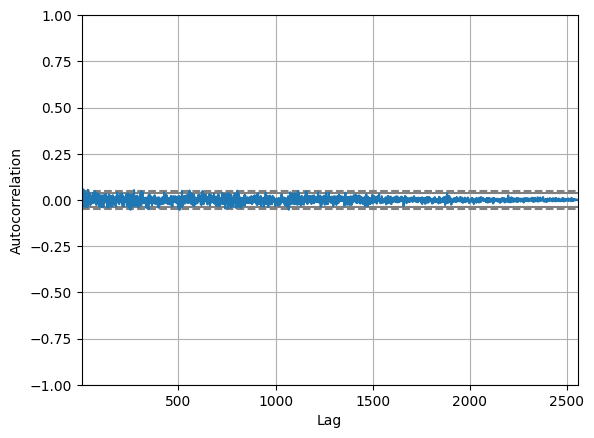

In [ ]:
autocorrelation_plot(Y_train)

In [ ]:
model_arima = ARIMA(endog=Y_train, exog=X_train, order=(0,1,7))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:      daily_log_returns   No. Observations:                 1461
Model:                 ARIMA(0, 1, 7)   Log Likelihood                2897.878
Date:                Fri, 05 May 2023   AIC                          -5713.756
Time:                        16:45:43   BIC                          -5497.022
Sample:                    01-01-2018   HQIC                         -5632.905
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Close                              -4.341e-06   3.51e-22  -1.24e+16      0.000   -4.34e-06   -4.34e-06
daily_volatility                     3.05e-05   2.36e-24   

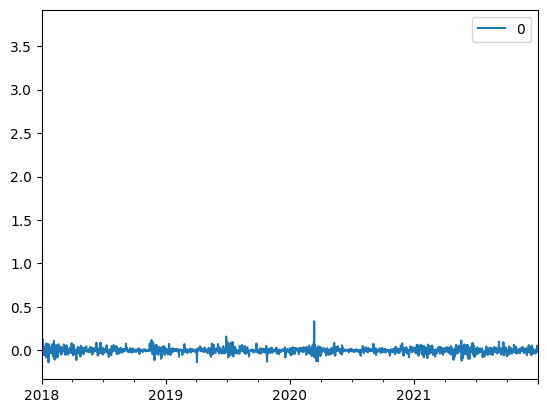

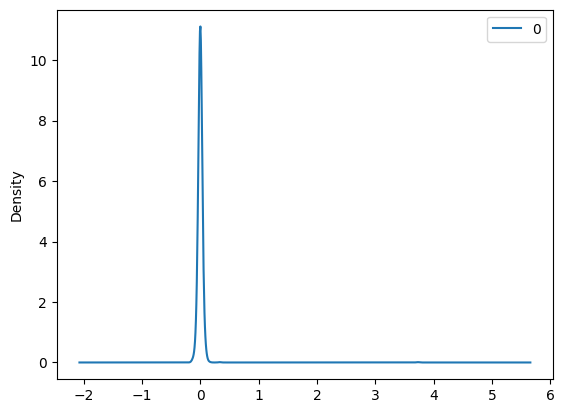

                 0
count  1461.000000
mean      0.001842
std       0.103025
min      -0.140100
25%      -0.016556
50%      -0.000544
75%       0.014179
max       3.726700


In [ ]:
model_fit = model_arima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
Y_pred_ARIMA = model_fit.forecast(exog=X_test, steps=X_test.shape[0])

In [ ]:
r2_score(Y_test, Y_pred_ARIMA)

-95948080.25930463

### Regressions

**Random Forest Regression**

In [ ]:
# Grid-Search for Best Parameters
"""
PARAMS_GS_RFR = {
    "n_estimators": [100, 1000, 5000],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

rfr = RandomForestReg({})
rfr.grid_search_CV(
    X_train=X_train, 
    Y_train=Y_train,
    param_grid=PARAMS_GS_RFR,
    cv=None, 
    refit=True,
    scoring='r2', 
    n_jobs=-1, 
    verbose=5,
)
"""

'\nPARAMS_GS_RFR = {\n    "n_estimators": [100, 1000, 5000],\n    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],\n    "max_depth": [None],\n    "max_features": ["sqrt", "log2", None],\n    "min_samples_leaf": [1, 2, 4],\n    "min_samples_split": [2, 5, 10],\n}\n\nrfr = RandomForestReg({})\nrfr.grid_search_CV(\n    X_train=X_train, \n    Y_train=Y_train,\n    param_grid=PARAMS_GS_RFR,\n    cv=None, \n    refit=True,\n    scoring=\'r2\', \n    n_jobs=-1, \n    verbose=5,\n)\n'

In [43]:
PARAMS_RFR = {
    "n_estimators": 100,
    "criterion": "squared_error",
    "max_depth": None,
    "max_features": None,
    "min_samples_leaf": 1,
}

rfr = RandomForestReg(**PARAMS_RFR)
rfr.fit_regressor(X_train, Y_train)
# make the prediction on the test set
Y_pred = rfr.predict_regressor(X_test)
# make the prediction on the out-of-sampling set
Y_pred_oos = rfr.predict_regressor(X_oos)
rfr.score_regressor(X_test, Y_test)

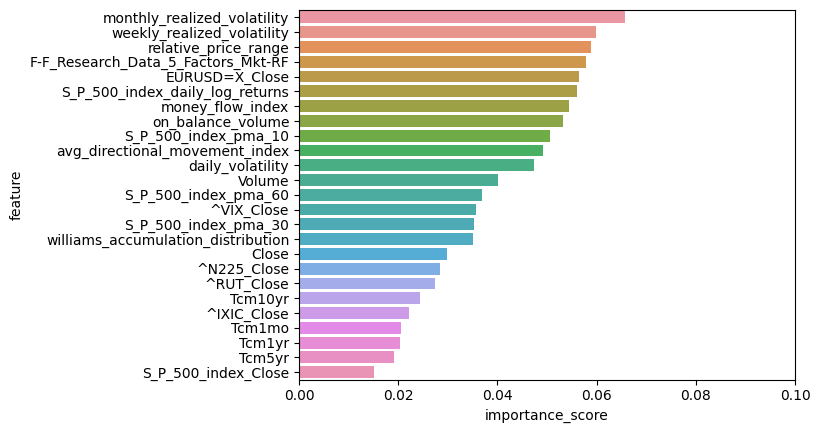

In [44]:
df_feat_imp = pd.DataFrame(
    [X_train.columns, rfr.regressor.feature_importances_], 
    index=["feature", "importance_score"]
    ).T.sort_values(by="importance_score", ascending=False)
sns.barplot(x=df_feat_imp["importance_score"], y=df_feat_imp["feature"], orient="horizonal")
plt.xlim(0, 0.1)
plt.show()

**Histogram Gradient Boosting Regressor**

In [45]:
PARAMS_HGBR = {
    "loss": "squared_error",
    "max_depth": None,
    "validation_fraction": 0.2,
}

hgbr = HistGradientBoostingReg(**PARAMS_HGBR)
hgbr.fit_regressor(X_train, Y_train)
Y_pred = hgbr.predict_regressor(X_test)
hgbr.score_regressor(X_test, Y_test)

**Stochastic Gradient Descent Regressor**

In [22]:
PARAMS_SGDR = {
    "loss": "squared_error",#"squared_error",
    "max_iter": 100,
    "penalty": "l2",
    "validation_fraction": 0.2,
    "early_stopping": True,
    "n_iter_no_change": 10,
    "learning_rate": "optimal",
}

sgdr = SGDReg(scaler="StandardScaler", **PARAMS_SGDR)
sgdr.fit_regressor(X_train, Y_train)
Y_pred = sgdr.predict_regressor(X_test)
sgdr.score_regressor(X_test, Y_test)

**Elastic Net Regressor**

In [ ]:
PARAMS_ENR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

enr = ElasticNetReg(**PARAMS_ENR)
enr.fit_regressor(X_train, Y_train)
Y_pred = enr.predict_regressor(X_test)
enr.score_regressor(X_test, Y_test)

**ThielSen Regressor**

In [ ]:
PARAMS_TSR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

tsr = TheilSenReg(**PARAMS_TSR)
tsr.fit_regressor(X_train, Y_train)
Y_pred = tsr.predict_regressor(X_test)
tsr.score_regressor(X_test, Y_test)

**RANSAC Regressor**

In [ ]:
PARAMS_RANSACR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

ransacr = RANSACReg(**PARAMS_RANSACR)
ransacr.fit_regressor(X_train, Y_train)
Y_pred = ransacr.predict_regressor(X_test)
ransacr.score_regressor(X_test, Y_test)

## Plot Prediction

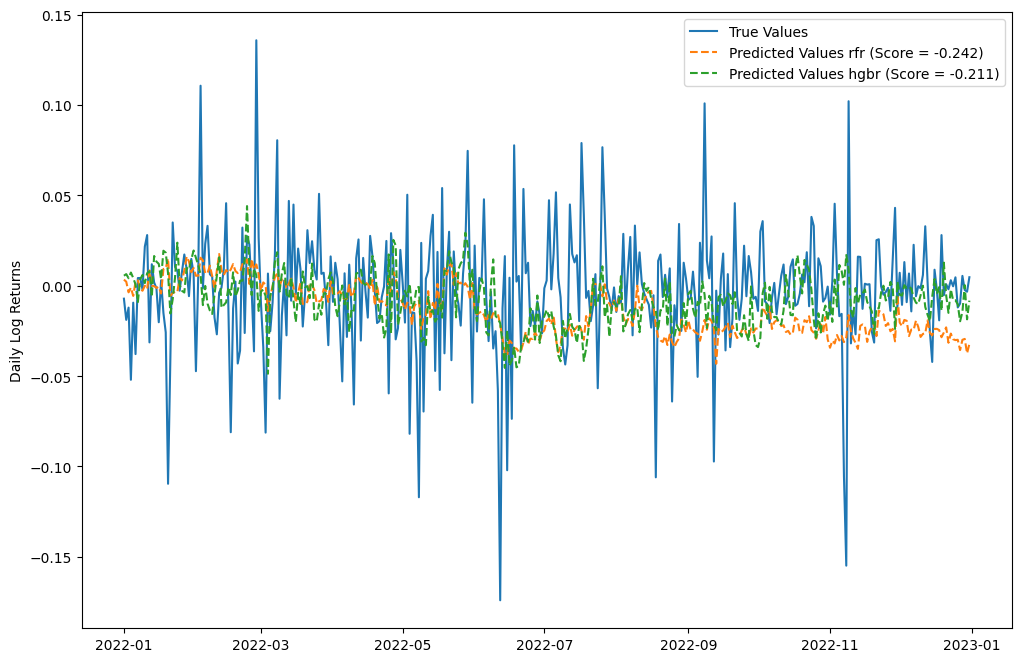

In [46]:
## Rest of the models are not good :(\

dict_regressors = {
    "rfr": rfr, 
    "hgbr": hgbr, 
    # "sgdr": sgdr, 
    # "enr": enr, 
    # "tsr": tsr, 
    # "ransacr": ransacr,
}

plt.figure(figsize=(12, 8))

PLOT_RANGE = ("2022-01-01", "2022-12-31")

plt.plot(Y_test[PLOT_RANGE[0]: PLOT_RANGE[1]], label="True Values")

for regressor_name, regressor in dict_regressors.items():
    # if regressor_name=='sgdr':
    #     continue
    plt.plot(
        regressor.predict_regressor(X_test)[PLOT_RANGE[0]: PLOT_RANGE[1]],
        label=f"Predicted Values {regressor_name} (Score = {round(regressor.score, 3)})",
        ls='--',
    )

# plt.plot(
#     Y_pred_ARIMA[PLOT_RANGE[0]: PLOT_RANGE[1]],
#     label=f"Predicted Values ARIMA (Score = {r2_score(Y_test, Y_pred_ARIMA)})",
#     ls='--'
#     )
# plt.title(f"Score= {round(rfr.score, 3)}")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.show()

# Test Set

## Trading Strategy

In [87]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the appropriate set to evaluate on
VALIDATIION_SET = 'test' # 'test' or 'out-of-sampling'

In [88]:
if VALIDATIION_SET == 'test':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_test)
    ds_daily_log_returns_true = Y_test
elif VALIDATIION_SET == 'out-of-sampling':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_oos)
    ds_daily_log_returns_true = Y_oos

**Trading Strategy from chosen regression model**

In [89]:
ds_close_pred = regression_model.calc_price_from_daily_log_returns(ds_daily_log_returns_pred, price_var='Close')
regression_trading_strategy = TradingStrategy(ds_daily_log_returns_pred, ds_close_pred)

**Trading Strategy from True Values**

In [90]:
if VALIDATIION_SET == 'test':
    true_ts = TradingStrategy(Y_test, X_test['Close'])
elif VALIDATIION_SET == 'out-of-sampling':
    true_ts = TradingStrategy(Y_oos, X_oos['Close'])

## Compare Baseline

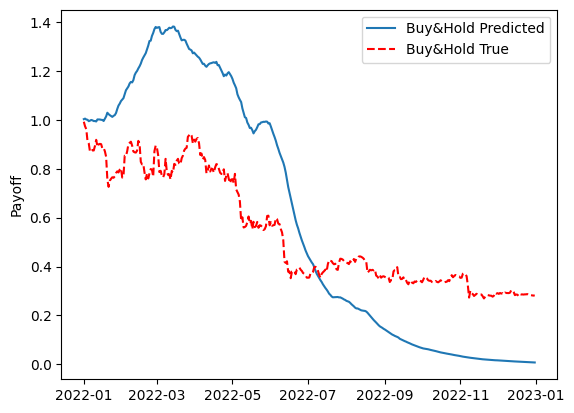

In [91]:
regression_baseline = regression_trading_strategy.strategy_buy_and_hold()
true_baseline = true_ts.strategy_buy_and_hold()

plt.plot(regression_baseline, label='Buy&Hold Predicted')
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
plt.plot(true_baseline, color='red', ls='--', label='Buy&Hold True')
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [92]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_regression_payoffs = regression_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [93]:
df_regression_payoffs#[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2022-01-01             0      1.000000              0       1.000000   
2022-01-02             0      1.000000              0       1.000000   
2022-01-03             0      1.000000              0       1.000000   
2022-01-04             0      1.000000              0       1.000000   
2022-01-05             0      1.000000              0       1.000000   
...                  ...           ...            ...            ...   
2022-12-27            -1    242.615625             -1     189.011840   
2022-12-28            -1    249.883930             -1     194.674278   
2022-12-29            -1    257.242071             -1     200.406702   
2022-12-30            -1    266.865863             -1     207.904202   
2022-12-31            -1    275.466480             -1     214.604589   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2022-01-01              0       1.000000               0        1.000000   
2022-01-02              0       1.000000               0        1.000000   
2022-01-03              0       1.000000               0        1.000000   
2022-01-04              0       1.000000               0        1.000000   
2022-01-05              0       1.000000               0        1.000000   
...                   ...            ...             ...             ...   
2022-12-27             -1     133.135698              -1       52.751433   
2022-12-28             -1     137.124192              -1       54.331766   
2022-12-29             -1     141.161983              -1       55.931632   
2022-12-30             -1     146.443054              -1       58.024114   
2022-12-31             -1     151.162656              -1       59.894129   

            signal_EMA_7  payoff_EMA_7  ...  signal_EMA30_RSI14  \
2022-01-01             0      1.000000  ...                   0   
2022-01-02             1      1.002196  ...                   1   
2022-01-03            -1      1.005888  ...                  -1   
2022-01-04            -1      1.006979  ...                  -1   
2022-01-05            -1      1.012685  ...                  -1   
...                  ...           ...  ...                 ...   
2022-12-27            -1    250.354191  ...                   0   
2022-12-28            -1    257.854329  ...                   0   
2022-12-29            -1    265.447168  ...                   0   
2022-12-30            -1    275.377924  ...                   0   
2022-12-31            -1    284.252870  ...                   0   

            payoff_EMA30_RSI14  signal_EMA90_RSI14  payoff_EMA90_RSI14  \
2022-01-01            1.000000                   0            1.000000   
2022-01-02            1.002196                   1            1.002196   
2022-01-03            1.005888                  -1            1.005888   
2022-01-04            1.006979                  -1            1.006979   
2022-01-05            1.012685                  -1            1.012685   
...                        ...                 ...                 ...   
2022-12-27            1.103471                   0            1.011832   
2022-12-28            1.103471                   0            1.011832   
2022-12-29            1.103471                   0            1.011832   
2022-12-30            1.103471                   0            1.011832   
2022-12-31            1.103471                   0            1.011832   

            signal_SMA90_RSI14  payoff_SMA90_RSI14  signal_SMA30_BBS7  \
2022-01-01                   0            1.000000                  0   
2022-01-02                   0            1.000000                  0   
2022-01-03                   0            1.000000                  0   
2022-01-04                   0            1.000000                  0   
2022-01-05                   0            1.000000                  0   
...                        ...                 ...                ...   
2022-12-27                   

In [94]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [95]:
df_true_payoffs#[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2022-01-01             0      1.000000              0       1.000000   
2022-01-02             0      1.000000              0       1.000000   
2022-01-03             0      1.000000              0       1.000000   
2022-01-04             0      1.000000              0       1.000000   
2022-01-05             0      1.000000              0       1.000000   
...                  ...           ...            ...            ...   
2022-12-27            -1      0.367199             -1       0.711530   
2022-12-28            -1      0.365213             -1       0.707681   
2022-12-29            -1      0.366086             -1       0.709374   
2022-12-30            -1      0.367303             -1       0.711732   
2022-12-31            -1      0.365585             -1       0.708403   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2022-01-01              0       1.000000               0        1.000000   
2022-01-02              0       1.000000               0        1.000000   
2022-01-03              0       1.000000               0        1.000000   
2022-01-04              0       1.000000               0        1.000000   
2022-01-05              0       1.000000               0        1.000000   
...                   ...            ...             ...             ...   
2022-12-27             -1       1.019626              -1        1.105312   
2022-12-28             -1       1.014112              -1        1.099334   
2022-12-29             -1       1.016537              -1        1.101963   
2022-12-30             -1       1.019916              -1        1.105626   
2022-12-31             -1       1.015145              -1        1.100454   

            signal_EMA_7  payoff_EMA_7  ...  signal_EMA30_RSI14  \
2022-01-01             0      1.000000  ...                   0   
2022-01-02            -1      1.018915  ...                  -1   
2022-01-03            -1      1.031283  ...                  -1   
2022-01-04            -1      1.084978  ...                  -1   
2022-01-05            -1      1.095188  ...                  -1   
...                  ...           ...  ...                 ...   
2022-12-27            -1      0.732456  ...                   0   
2022-12-28            -1      0.728494  ...                  -1   
2022-12-29            -1      0.730236  ...                  -1   
2022-12-30            -1      0.732663  ...                  -1   
2022-12-31            -1      0.729236  ...                  -1   

            payoff_EMA30_RSI14  signal_EMA90_RSI14  payoff_EMA90_RSI14  \
2022-01-01            1.000000                   0            1.000000   
2022-01-02            1.018915                  -1            1.018915   
2022-01-03            1.031283                  -1            1.031283   
2022-01-04            1.084978                  -1            1.084978   
2022-01-05            1.095188                  -1            1.095188   
...                        ...                 ...                 ...   
2022-12-27            0.780748                   0            1.188626   
2022-12-28            0.776526                  -1            1.182197   
2022-12-29            0.778383                  -1            1.185025   
2022-12-30            0.780970                  -1            1.188963   
2022-12-31            0.777317                  -1            1.183402   

            signal_SMA90_RSI14  payoff_SMA90_RSI14  signal_SMA30_BBS7  \
2022-01-01                   0            1.000000                  0   
2022-01-02                   0            1.000000                  0   
2022-01-03                   0            1.000000                  0   
2022-01-04                   0            1.000000                  0   
2022-01-05                   0            1.000000                  0   
...                        ...                 ...                ...   
2022-12-27                   

## Performance

In [110]:
df_regression_signals_test = df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]
signal_buy_and_hold = pd.Series(
    data=[1]*len(df_regression_signals_test), 
    index=df_regression_signals_test.index,
    name="signal_buy_and_hold", 
    )
df_regression_signals_test = pd.concat([signal_buy_and_hold, df_regression_signals_test], axis=1)
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals_test,
)

In [97]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

buy_and_hold     SMA_7    SMA_30    SMA_90  \
cumulative_return            -0.717846  1.012669  1.199349  0.825806   
annualized_return            -0.717846  1.012669  1.199349  0.825806   
average_daily_log_returns    -0.002887  0.002464   0.00268  0.002057   
annualized_volatility         0.641409   0.63829  0.622521  0.551181   
sharpe_ratio                 -0.085991   0.07375  0.082237  0.071296   
annualized_sharpe_ratio      -0.085991   0.07375  0.082237  0.071296   
sortino_ratio                 -0.10567  0.118688   0.13232  0.108529   
max_drawdown                   2.28202  1.629722  1.586245  1.586245   
calmar_ratio                 -0.314566  0.621375  0.756093  0.520604   

                            SMA_180     EMA_7    EMA_30    EMA_90   EMA_180  \
cumulative_return          0.100454  1.278627  1.031255  1.441948  0.850856   
annualized_return          0.100454  1.278627  1.031255  1.441948  0.850856   
average_daily_log_returns  0.000477   0.00281  0.002496  0.003001  0.002242   
annualized_volatility      0.398657  0.641493  0.641969  0.641178  0.642312   
sharpe_ratio               0.022845  0.083698  0.074285  0.089409  0.066693   
annualized_sharpe_ratio    0.022845  0.083698  0.074285  0.089409  0.066693   
sortino_ratio               0.03201  0.135408  0.118654  0.140133  0.103293   
max_drawdown               1.658775  1.629722  1.629722  1.629722  1.629722   
calmar_ratio               0.060559  0.784567   0.63278  0.884782  0.522086   

                              BBS_7  ...    BBS_30     RSI_7    RSI_14  \
cumulative_return          0.007854  ... -0.561609 -0.707706 -0.610626   
annualized_return          0.007854  ... -0.561609 -0.707706 -0.610626   
average_daily_log_returns  0.000022  ... -0.002092  -0.00283 -0.002036   
annualized_volatility      0.024346  ...  0.336273  0.616371  0.622663   
sharpe_ratio               0.017449  ... -0.118865 -0.087724 -0.062479   
annualized_sharpe_ratio    0.017449  ... -0.118865 -0.087724 -0.062479   
sortino_ratio              0.042651  ... -0.127542 -0.101754 -0.072829   
max_drawdown               1.420209  ...  3.241414  2.588003  2.588003   
calmar_ratio                0.00553  ... -0.173261 -0.273456 -0.235945   

                             RSI_30 SMA30_RSI14 EMA30_RSI14 EMA90_RSI14  \
cumulative_return         -0.734209    0.164251    0.092514    0.244158   
annualized_return         -0.734209    0.164251    0.092514    0.244158   
average_daily_log_returns -0.003085    0.000466    0.000282    0.000655   
annualized_volatility      0.618424    0.191878    0.171324    0.203828   
sharpe_ratio              -0.095314    0.046393    0.031498    0.061427   
annualized_sharpe_ratio   -0.095314    0.046393    0.031498    0.061427   
sortino_ratio             -0.110278     0.08299    0.047192    0.091823   
max_drawdown               2.705772    1.680557    2.152058    2.152058   
calmar_ratio              -0.271349    0.097736    0.042989    0.113453   

                          SMA90_RSI14 SMA30_BBS7 EMA90_BBS7  
cumulative_return            0.017435   1.217741   1.462583  
annualized_return            0.017435   1.217741   1.462583  
average_daily_log_returns    0.000214   0.002702   0.003023  
annualized_volatility        0.346529   0.622149   0.640677  
sharpe_ratio                 0.011794   0.082969   0.090142  
annualized_sharpe_ratio      0.011794   0.082969   0.090142  
sortino_ratio                0.015346   0.133553   0.140799  
max_drawdown                 2.238672   1.586245   1.629722  
calmar_ratio                 0.007788   0.767688   0.897443  

[9 rows x 21 columns]

### Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

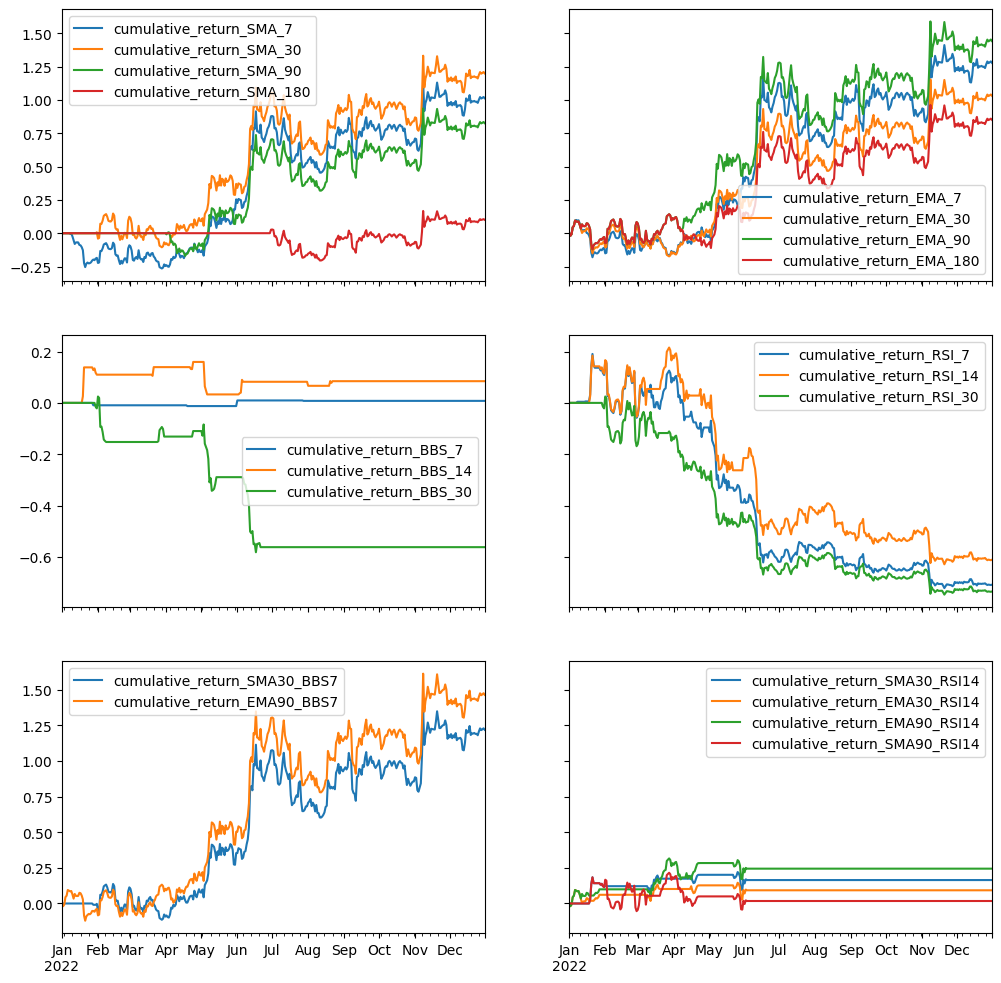

In [98]:
METRIC = 'cumulative_return'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

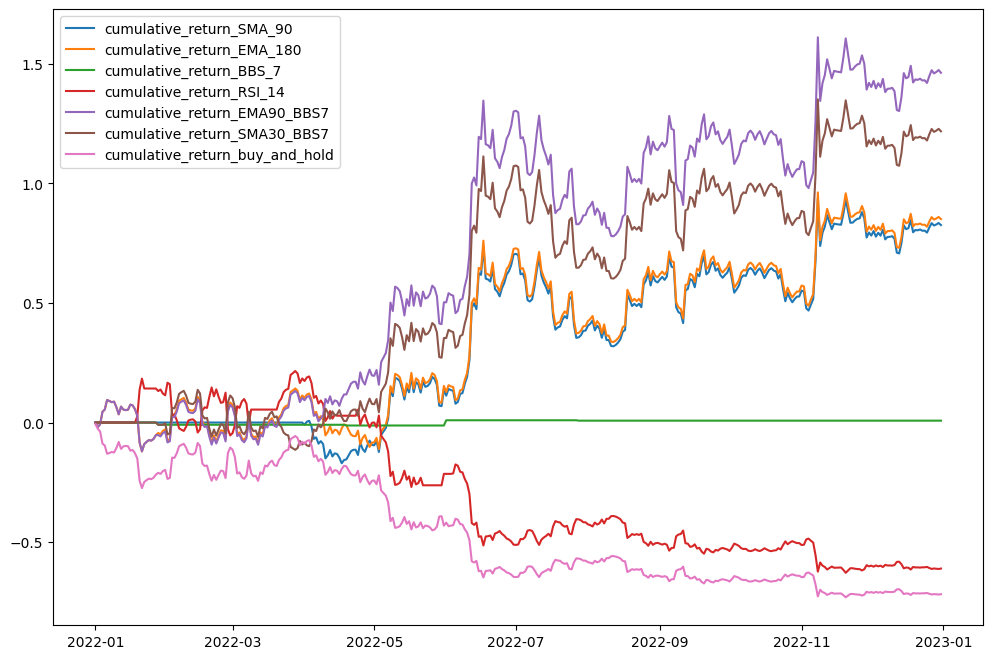

In [99]:
BEST_STRATEGIES = ['SMA_90', 'EMA_180', 'BBS_7', 'RSI_14', 'EMA90_BBS7', 'SMA30_BBS7', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.show()

**Compare Sharpe Ratio**

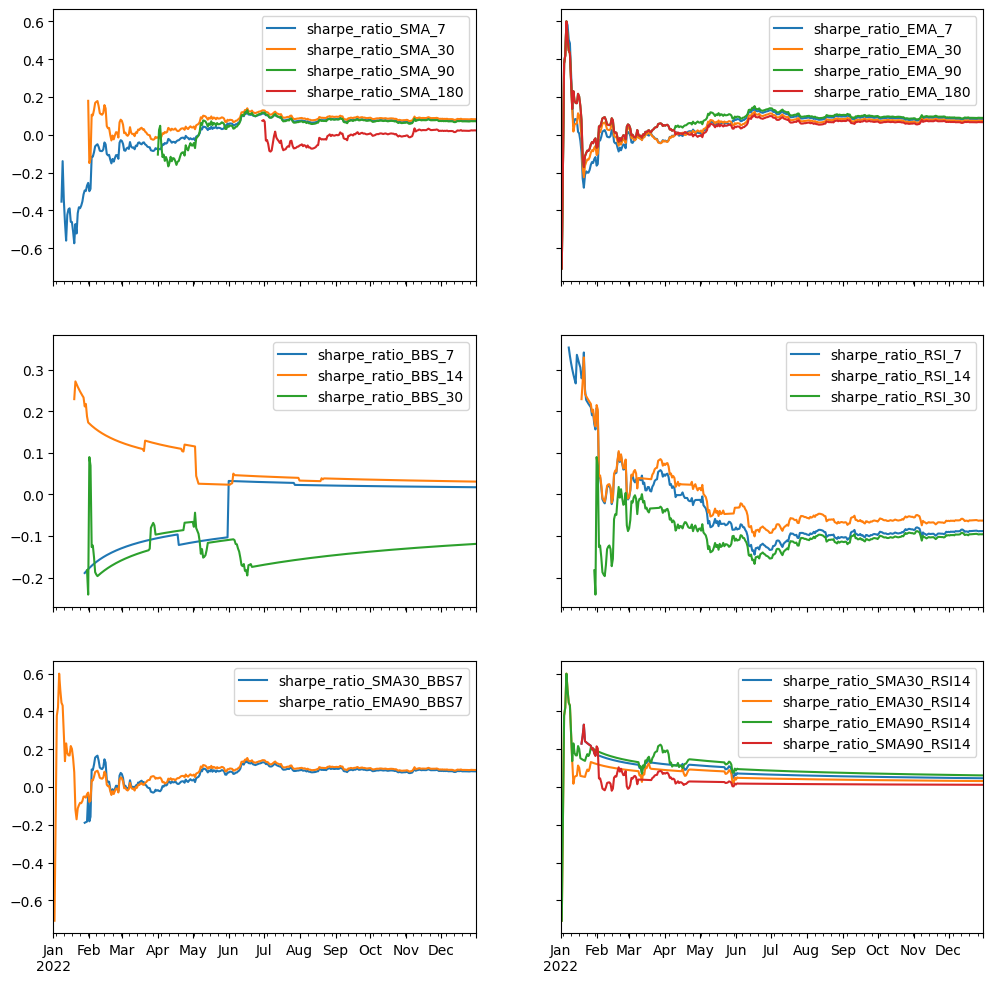

In [70]:
METRIC = 'sharpe_ratio'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

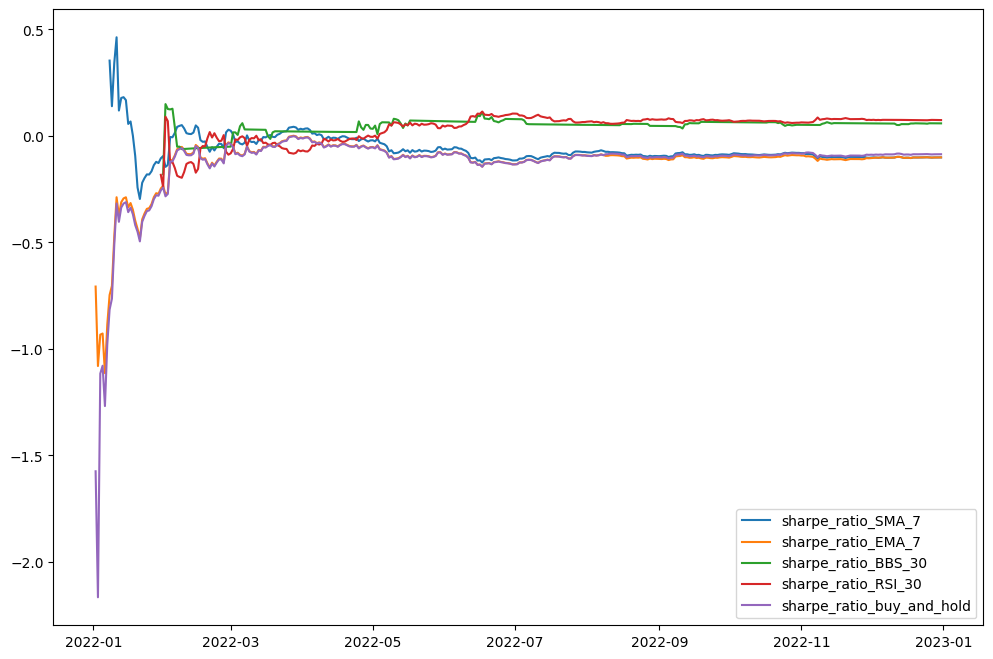

In [63]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
plt.legend()
plt.show()

# Out of Sampling Set

## Trading Strategy

In [71]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the appropriate set to evaluate on
VALIDATIION_SET = 'out-of-sampling' # 'test' or 'out-of-sampling'

In [72]:
if VALIDATIION_SET == 'test':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_test)
    ds_daily_log_returns_true = Y_test
elif VALIDATIION_SET == 'out-of-sampling':
    ds_daily_log_returns_pred = regression_model.predict_regressor(X_oos)
    ds_daily_log_returns_true = Y_oos

**Trading Strategy from chosen regression model**

In [73]:
ds_close_pred = regression_model.calc_price_from_daily_log_returns(ds_daily_log_returns_pred, price_var='Close')
regression_trading_strategy = TradingStrategy(ds_daily_log_returns_pred, ds_close_pred)

**Trading Strategy from True Values**

In [74]:
if VALIDATIION_SET == 'test':
    true_ts = TradingStrategy(Y_test, X_test['Close'])
elif VALIDATIION_SET == 'out-of-sampling':
    true_ts = TradingStrategy(Y_oos, X_oos['Close'])

## Compare Baseline

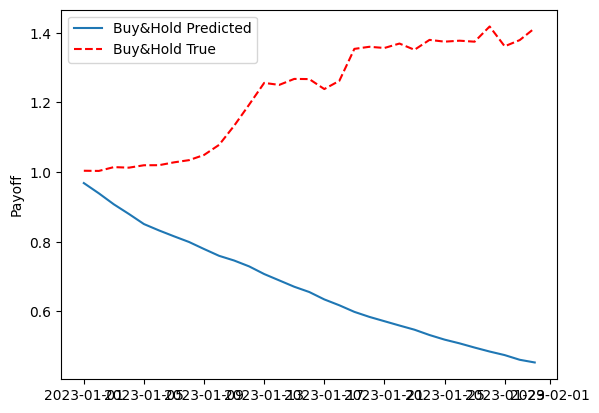

In [75]:
regression_baseline = regression_trading_strategy.strategy_buy_and_hold()
true_baseline = true_ts.strategy_buy_and_hold()

plt.plot(regression_baseline, label='Buy&Hold Predicted')
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
plt.plot(true_baseline, color='red', ls='--', label='Buy&Hold True')
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [76]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_regression_payoffs = regression_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [77]:
df_regression_payoffs#[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2023-01-01             0      1.000000              0       1.000000   
2023-01-02             0      1.000000              0       1.000000   
2023-01-03             0      1.000000              0       1.000000   
2023-01-04             0      1.000000              0       1.000000   
2023-01-05             0      1.000000              0       1.000000   
2023-01-06             0      1.000000              0       1.000000   
2023-01-07             0      1.000000              0       1.000000   
2023-01-08            -1      1.020006              0       1.000000   
2023-01-09            -1      1.045818              0       1.000000   
2023-01-10            -1      1.071998              0       1.000000   
2023-01-11            -1      1.090994              0       1.000000   
2023-01-12            -1      1.115667              0       1.000000   
2023-01-13            -1      1.149240              0       1.000000   
2023-01-14            -1      1.178840              0       1.000000   
2023-01-15            -1      1.210039              0       1.000000   
2023-01-16            -1      1.237367              0       1.000000   
2023-01-17            -1      1.277469              0       1.000000   
2023-01-18            -1      1.311403              0       1.000000   
2023-01-19            -1      1.351465              0       1.000000   
2023-01-20            -1      1.384066              0       1.000000   
2023-01-21            -1      1.413398              0       1.000000   
2023-01-22            -1      1.443987              0       1.000000   
2023-01-23            -1      1.474982              0       1.000000   
2023-01-24            -1      1.516110              0       1.000000   
2023-01-25            -1      1.553664              0       1.000000   
2023-01-26            -1      1.585856              0       1.000000   
2023-01-27            -1      1.623514              0       1.000000   
2023-01-28            -1      1.660820              0       1.000000   
2023-01-29            -1      1.695720              0       1.000000   
2023-01-30            -1      1.743764              0       1.000000   
2023-01-31            -1      1.773106             -1       1.016826   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2023-01-01              0            1.0               0             1.0   
2023-01-02              0            1.0               0             1.0   
2023-01-03              0            1.0               0             1.0   
2023-01-04              0            1.0               0             1.0   
2023-01-05              0            1.0               0             1.0   
2023-01-06              0            1.0               0             1.0   
2023-01-07              0            1.0               0             1.0   
2023-01-08              0            1.0               0             1.0   
2023-01-09              0            1.0               0             1.0   
2023-01-10              0            1.0               0             1.0   
2023-01-11              0            1.0               0             1.0   
2023-01-12              0            1.0               0             1.0   
2023-01-13              0            1.0               0             1.0   
2023-01-14              0            1.0               0             1.0   
2023-01-15              0            1.0               0             1.0   
2023-01-16              0            1.0               0             1.0   
2023-01-17              0            1.0               0             1.0   
2023-01-18              0            1.0               0             1.0   
2023-01-19              0            1.0               0             1.0   
2023-01-20              0            1.0               0             1.0   
2023-01-21              0            1.0               0             1.0   
2023-01-22              0          

In [78]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30',
    'SMA30_RSI14', 'EMA30_RSI14', 
    'EMA90_RSI14', 'SMA90_RSI14', 
    'SMA30_BBS7', 'EMA90_BBS7',
    ]

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [79]:
df_true_payoffs#[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

signal_SMA_7  payoff_SMA_7  signal_SMA_30  payoff_SMA_30  \
2023-01-01             0      1.000000              0       1.000000   
2023-01-02             0      1.000000              0       1.000000   
2023-01-03             0      1.000000              0       1.000000   
2023-01-04             0      1.000000              0       1.000000   
2023-01-05             0      1.000000              0       1.000000   
2023-01-06             0      1.000000              0       1.000000   
2023-01-07             0      1.000000              0       1.000000   
2023-01-08             1      1.006149              0       1.000000   
2023-01-09             1      1.020655              0       1.000000   
2023-01-10             1      1.048847              0       1.000000   
2023-01-11             1      1.102132              0       1.000000   
2023-01-12             1      1.161260              0       1.000000   
2023-01-13             1      1.221869              0       1.000000   
2023-01-14             1      1.216294              0       1.000000   
2023-01-15             1      1.233003              0       1.000000   
2023-01-16             1      1.232530              0       1.000000   
2023-01-17             1      1.204684              0       1.000000   
2023-01-18             1      1.227640              0       1.000000   
2023-01-19             1      1.316870              0       1.000000   
2023-01-20             1      1.322726              0       1.000000   
2023-01-21             1      1.319400              0       1.000000   
2023-01-22             1      1.331770              0       1.000000   
2023-01-23             1      1.314354              0       1.000000   
2023-01-24             1      1.342012              0       1.000000   
2023-01-25             1      1.337064              0       1.000000   
2023-01-26             1      1.339729              0       1.000000   
2023-01-27             1      1.336961              0       1.000000   
2023-01-28             1      1.379438              0       1.000000   
2023-01-29             1      1.324127              0       1.000000   
2023-01-30            -1      1.306897              0       1.000000   
2023-01-31             1      1.339498              1       1.024946   

            signal_SMA_90  payoff_SMA_90  signal_SMA_180  payoff_SMA_180  \
2023-01-01              0            1.0               0             1.0   
2023-01-02              0            1.0               0             1.0   
2023-01-03              0            1.0               0             1.0   
2023-01-04              0            1.0               0             1.0   
2023-01-05              0            1.0               0             1.0   
2023-01-06              0            1.0               0             1.0   
2023-01-07              0            1.0               0             1.0   
2023-01-08              0            1.0               0             1.0   
2023-01-09              0            1.0               0             1.0   
2023-01-10              0            1.0               0             1.0   
2023-01-11              0            1.0               0             1.0   
2023-01-12              0            1.0               0             1.0   
2023-01-13              0            1.0               0             1.0   
2023-01-14              0            1.0               0             1.0   
2023-01-15              0            1.0               0             1.0   
2023-01-16              0            1.0               0             1.0   
2023-01-17              0            1.0               0             1.0   
2023-01-18              0            1.0               0             1.0   
2023-01-19              0            1.0               0             1.0   
2023-01-20              0            1.0               0             1.0   
2023-01-21              0            1.0               0             1.0   
2023-01-22              0          

## Performance

In [80]:
df_regression_signals_oos = df_regression_payoffs[[col for col in df_regression_payoffs.columns if col.startswith("signal")]]
signal_buy_and_hold = pd.Series(
    data=[1]*len(df_regression_signals_oos), 
    index=df_regression_signals_oos.index,
    name="signal_buy_and_hold", 
    )
df_regression_signals_oos = pd.concat([signal_buy_and_hold, df_regression_signals_oos], axis=1)
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals_oos,
)

In [81]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

buy_and_hold     SMA_7    SMA_30 SMA_90 SMA_180  \
cumulative_return             0.413185 -0.286851 -0.024946    0.0     0.0   
annualized_return            57.677792 -0.981323 -0.257284    0.0     0.0   
average_daily_log_returns      0.01147 -0.010578 -0.000805    0.0     0.0   
annualized_volatility          0.43963  0.444615  0.085598    0.0     0.0   
sharpe_ratio                  0.498445 -0.454532 -0.179605    NaN     NaN   
annualized_sharpe_ratio        1.71034 -1.559659 -0.616289    NaN     NaN   
sortino_ratio                 0.886172 -0.500537 -0.179605    NaN     NaN   
max_drawdown                  1.551657  2.812722       inf    NaN     NaN   
calmar_ratio                  37.17175 -0.348887      -0.0    NaN     NaN   

                              EMA_7    EMA_30    EMA_90   EMA_180 BBS_7  ...  \
cumulative_return         -0.303735 -0.303735 -0.303735 -0.303735   0.0  ...   
annualized_return         -0.985914 -0.985914 -0.985914 -0.985914   0.0  ...   
average_daily_log_returns -0.011347 -0.011347 -0.011347 -0.011347   0.0  ...   
annualized_volatility       0.44063   0.44063   0.44063   0.44063   0.0  ...   
sharpe_ratio               -0.49199  -0.49199  -0.49199  -0.49199   NaN  ...   
annualized_sharpe_ratio   -1.688194 -1.688194 -1.688194 -1.688194   NaN  ...   
sortino_ratio             -0.557873 -0.557873 -0.557873 -0.557873   NaN  ...   
max_drawdown               2.812722  2.812722  2.812722  2.812722   NaN  ...   
calmar_ratio              -0.350519 -0.350519 -0.350519 -0.350519   NaN  ...   

                          BBS_30      RSI_7    RSI_14    RSI_30 SMA30_RSI14  \
cumulative_return            0.0   0.385807  0.125176  0.038283    0.097791   
annualized_return            0.0  45.605221   3.00939  0.556334    1.999744   
average_daily_log_returns    0.0   0.010836   0.00397  0.001224    0.003166   
annualized_volatility        0.0   0.443145  0.349435  0.095214    0.341613   
sharpe_ratio                 NaN   0.467156   0.21708  0.245689    0.177047   
annualized_sharpe_ratio      NaN   1.602977   0.74488  0.843047    0.607512   
sortino_ratio                NaN   0.928949   0.40135       inf    0.326484   
max_drawdown                 NaN   1.551657  1.551657       1.0    1.551657   
calmar_ratio                 NaN   29.39131  1.939469  0.556334     1.28878   

                          EMA30_RSI14 EMA90_RSI14 SMA90_RSI14 SMA30_BBS7  \
cumulative_return           -0.208278   -0.208278    0.125176  -0.024946   
annualized_return           -0.936059   -0.936059     3.00939  -0.257284   
average_daily_log_returns   -0.007377   -0.007377     0.00397  -0.000805   
annualized_volatility        0.306827    0.306827    0.349435   0.085598   
sharpe_ratio                -0.459314   -0.459314     0.21708  -0.179605   
annualized_sharpe_ratio     -1.576071   -1.576071     0.74488  -0.616289   
sortino_ratio               -0.448169   -0.448169     0.40135  -0.179605   
max_drawdown                35.110255   35.110255    1.551657        inf   
calmar_ratio                -0.026661   -0.026661    1.939469       -0.0   

                          EMA90_BBS7  
cumulative_return          -0.303735  
annualized_return          -0.985914  
average_daily_log_returns  -0.011347  
annualized_volatility        0.44063  
sharpe_ratio                -0.49199  
annualized_sharpe_ratio    -1.688194  
sortino_ratio              -0.557873  
max_drawdown                2.812722  
calmar_ratio               -0.350519  

[9 rows x 21 columns]

### Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

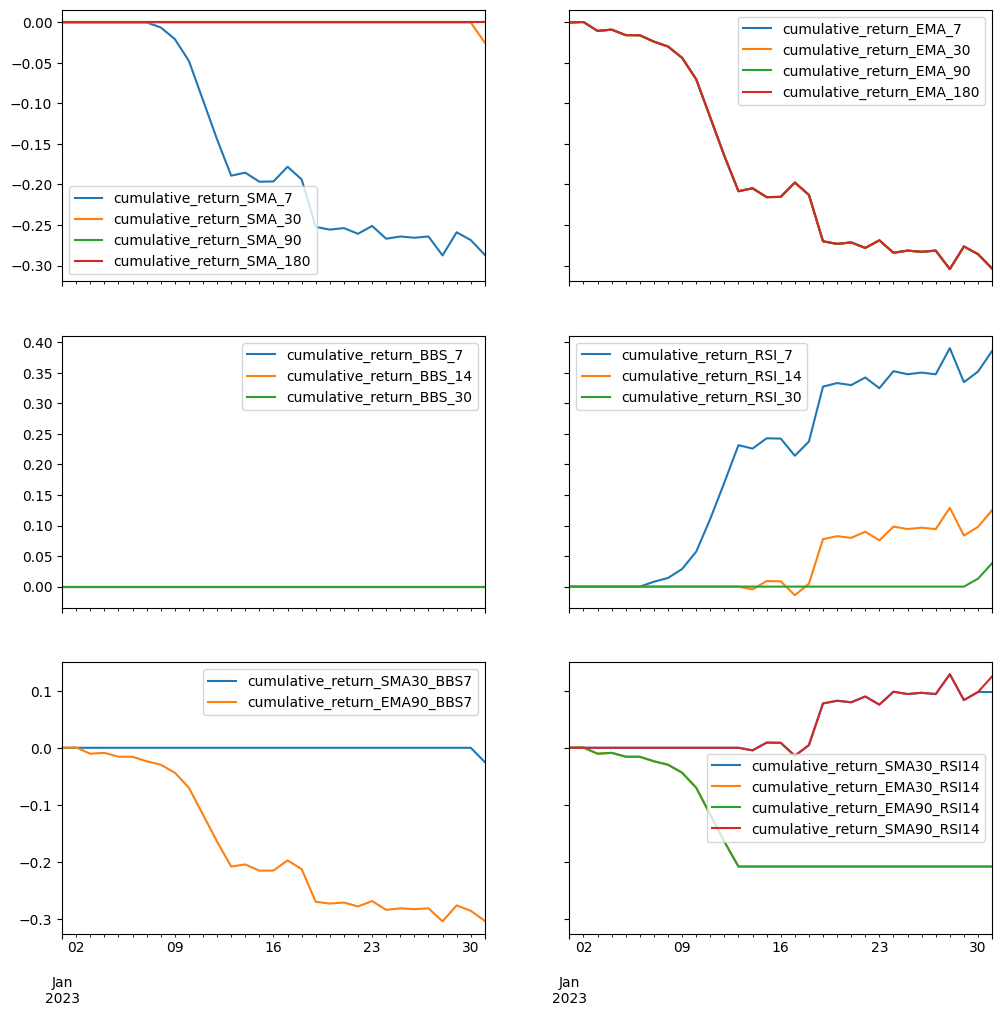

In [83]:
METRIC = 'cumulative_return'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

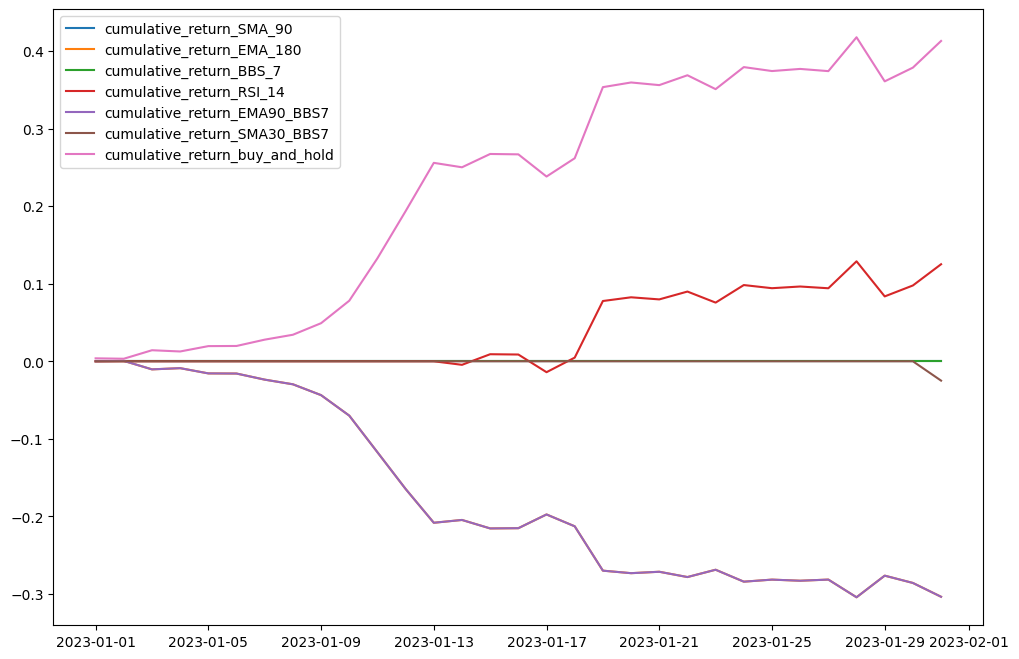

In [84]:
BEST_STRATEGIES = ['SMA_90', 'EMA_180', 'BBS_7', 'RSI_14', 'EMA90_BBS7', 'SMA30_BBS7', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.show()

**Compare Sharpe Ratio**

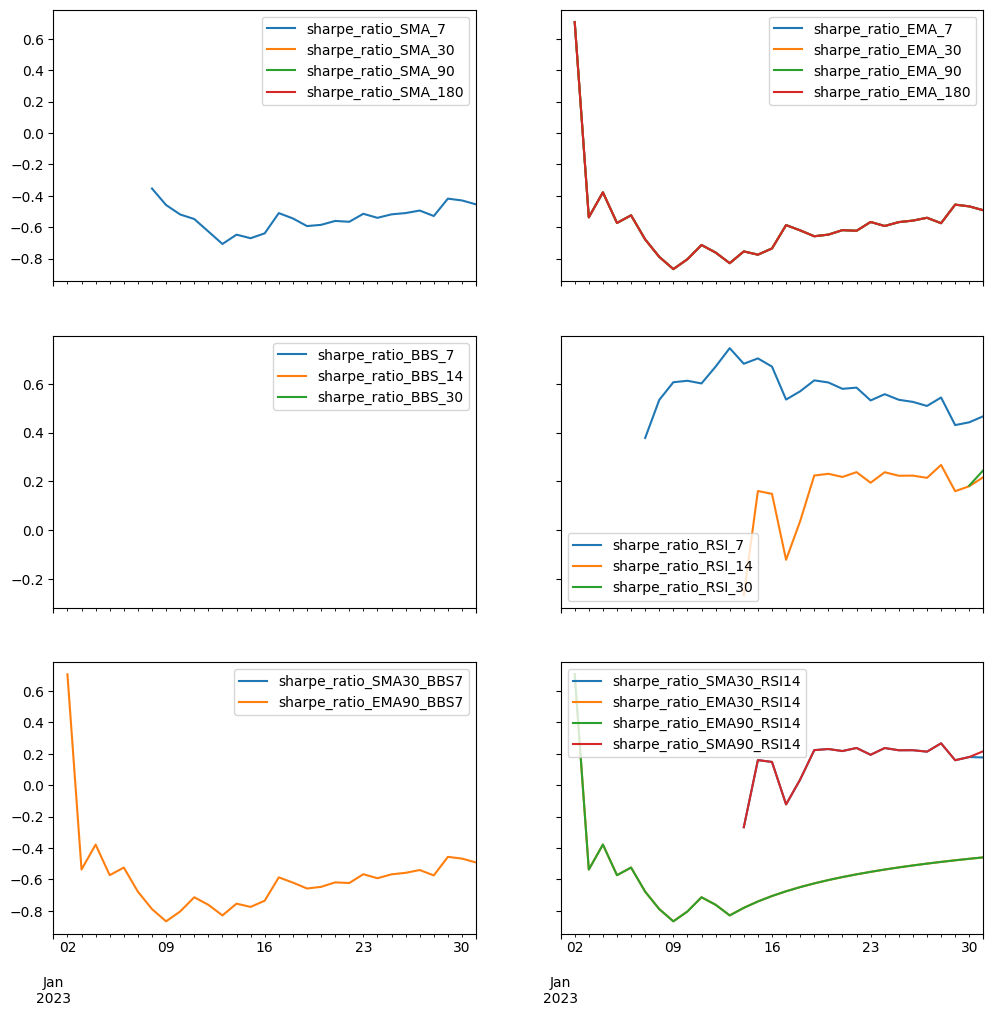

In [85]:
METRIC = 'sharpe_ratio'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.show()

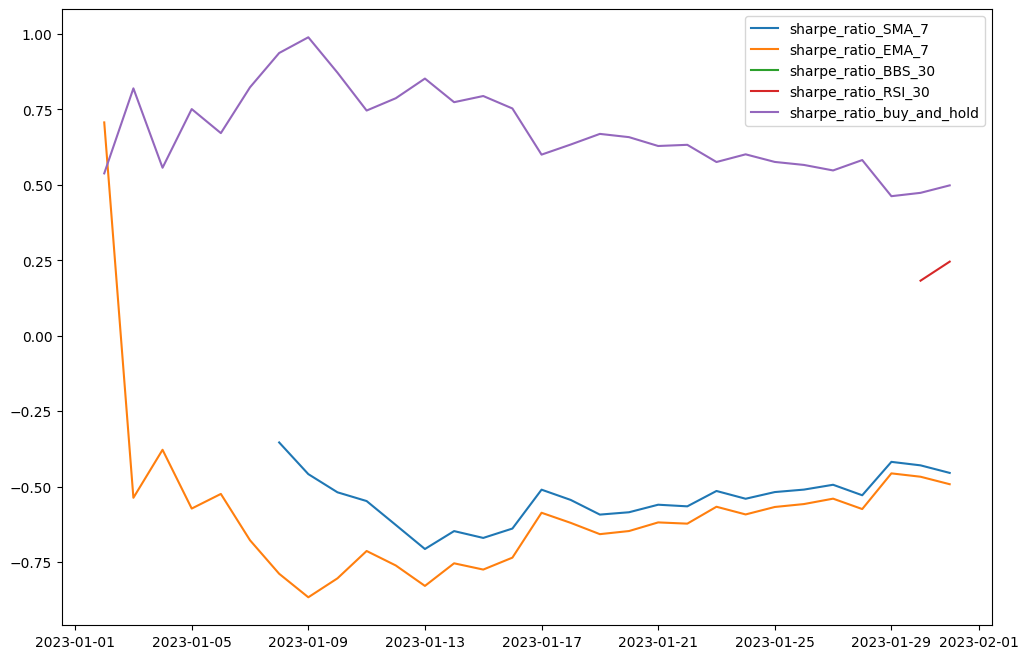

In [86]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
plt.legend()
plt.show()

# Robustness Test

## Trading Strategy

In [107]:
# initialize this as the object of the chosen regression model
regression_model = rfr
# select the name of target asset to evaluate on
ROBUSTNESS_SET = 'ETH-USD' # 'ETH-USD'

df_asset_val = dict_assets[ROBUSTNESS_SET][TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]

X_rob, Y_rob = df_asset_val[FEATURES_LIST_HAND_PICKED], df_asset_val[TARGET]

ds_daily_log_returns_true = Y_rob

## Performance

In [111]:
perf_m = PerformanceMetrics(
    ds_daily_log_returns_true, 
    df_regression_signals_test,
)

In [112]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

df_performance_metrics_last, df_performance_metrics = perf_m.compute_performance_metrics(performance_metrics)
df_performance_metrics_last

buy_and_hold     SMA_7    SMA_30    SMA_90  \
cumulative_return            -0.779863  0.615088  0.971007  0.844073   
annualized_return            -0.779863  0.615088  0.971007  0.844073   
average_daily_log_returns    -0.003079  0.002332  0.002807  0.002501   
annualized_volatility         0.871352  0.865463  0.836532  0.779608   
sharpe_ratio                 -0.067519   0.05148   0.06411  0.061286   
annualized_sharpe_ratio      -0.067519   0.05148   0.06411  0.061286   
sortino_ratio                -0.088357  0.076871  0.096599  0.086809   
max_drawdown                  2.152302  1.867828  1.867828  1.867828   
calmar_ratio                 -0.362339  0.329306  0.519859  0.451901   

                            SMA_180     EMA_7    EMA_30    EMA_90   EMA_180  \
cumulative_return         -0.236778  0.652678  0.847214  1.315735  0.726547   
annualized_return         -0.236778  0.652678  0.847214  1.315735  0.726547   
average_daily_log_returns -0.000234   0.00241  0.002714  0.003334  0.002531   
annualized_volatility      0.608843   0.87181  0.871482  0.870695  0.871684   
sharpe_ratio              -0.007331  0.052822  0.059508  0.073158  0.055476   
annualized_sharpe_ratio   -0.007331  0.052822  0.059508  0.073158  0.055476   
sortino_ratio             -0.009729  0.079753  0.090551  0.108818   0.08221   
max_drawdown               1.867828  1.867828  1.867828  1.867828  1.867828   
calmar_ratio              -0.126767  0.349432  0.453583   0.70442  0.388979   

                              BBS_7  ...    BBS_30     RSI_7    RSI_14  \
cumulative_return         -0.048471  ... -0.625267 -0.714062 -0.580871   
annualized_return         -0.048471  ... -0.625267 -0.714062 -0.580871   
average_daily_log_returns -0.000123  ... -0.002454 -0.002469 -0.001408   
annualized_volatility       0.09769  ...  0.399024  0.827691  0.835491   
sharpe_ratio              -0.024026  ... -0.117502  -0.05699  -0.03219   
annualized_sharpe_ratio   -0.024026  ... -0.117502  -0.05699  -0.03219   
sortino_ratio             -0.029127  ... -0.128085 -0.071698 -0.040471   
max_drawdown                2.18812  ...  2.439445  2.152302  2.152302   
calmar_ratio              -0.022152  ... -0.256315 -0.331767 -0.269883   

                             RSI_30 SMA30_RSI14 EMA30_RSI14 EMA90_RSI14  \
cumulative_return          -0.77564    0.566125      0.5185    0.657676   
annualized_return          -0.77564    0.566125      0.5185    0.657676   
average_daily_log_returns -0.003117    0.001324    0.001231    0.001496   
annualized_volatility      0.833151    0.267365    0.252211     0.28469   
sharpe_ratio              -0.071487    0.094616    0.093283    0.100402   
annualized_sharpe_ratio   -0.071487    0.094616    0.093283    0.100402   
sortino_ratio             -0.090383    0.188021    0.155375    0.156252   
max_drawdown               2.152302    1.606546    2.288543    2.288543   
calmar_ratio              -0.360377    0.352387    0.226563    0.287378   

                          SMA90_RSI14 SMA30_BBS7 EMA90_BBS7  
cumulative_return            0.443283   0.888721   1.224607  
annualized_return            0.443283   0.888721   1.224607  
average_daily_log_returns    0.001227   0.002684   0.003211  
annualized_volatility        0.402537   0.833959   0.865364  
sharpe_ratio                 0.058214   0.061493   0.070897  
annualized_sharpe_ratio      0.058214   0.061493   0.070897  
sortino_ratio                0.083133   0.092301   0.104369  
max_drawdown                 1.673536   1.867828   1.867828  
calmar_ratio                 0.264878   0.475804   0.655631  

[9 rows x 21 columns]

### Plots to analyse trading strategies across performance metrics

**Comapre Cumulative Returns**

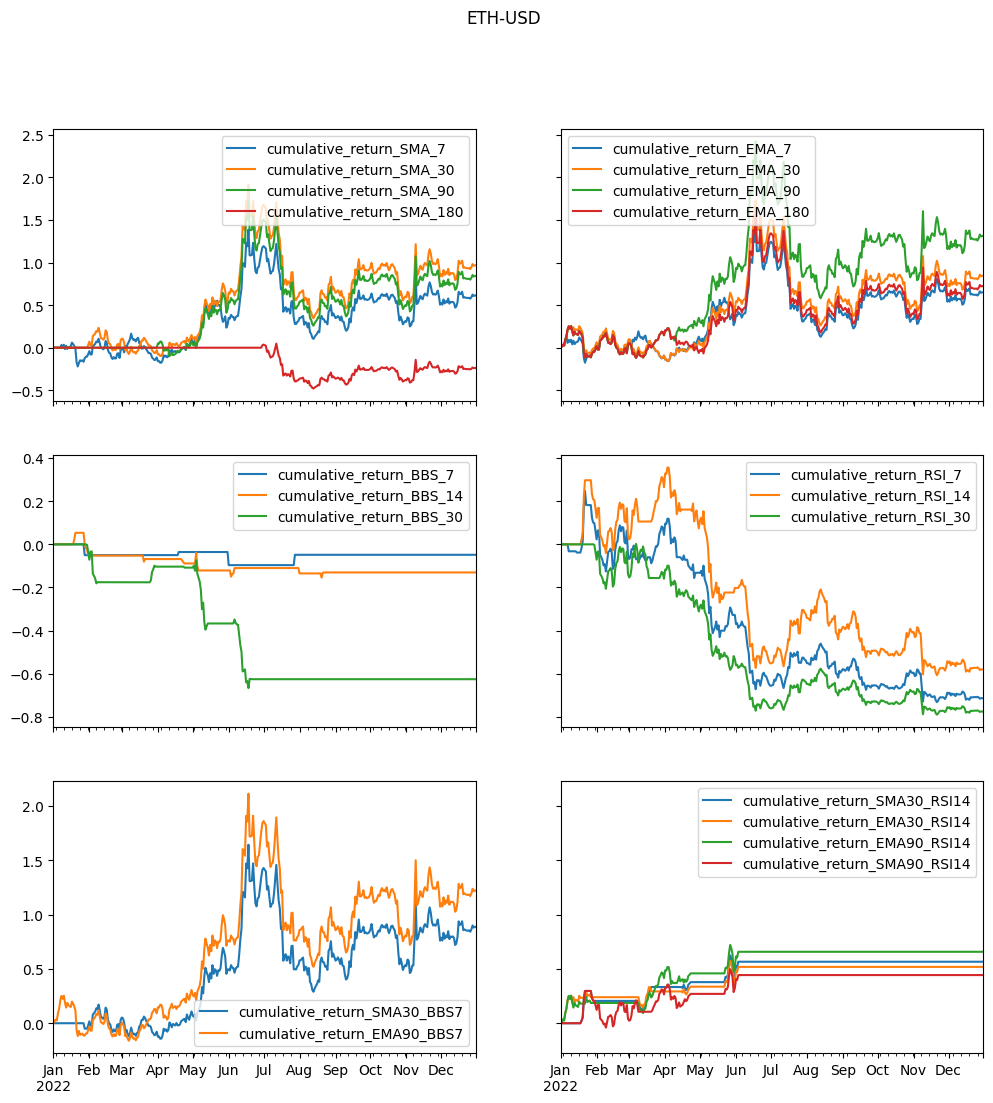

In [117]:
METRIC = 'cumulative_return'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.suptitle(ROBUSTNESS_SET)
plt.show()

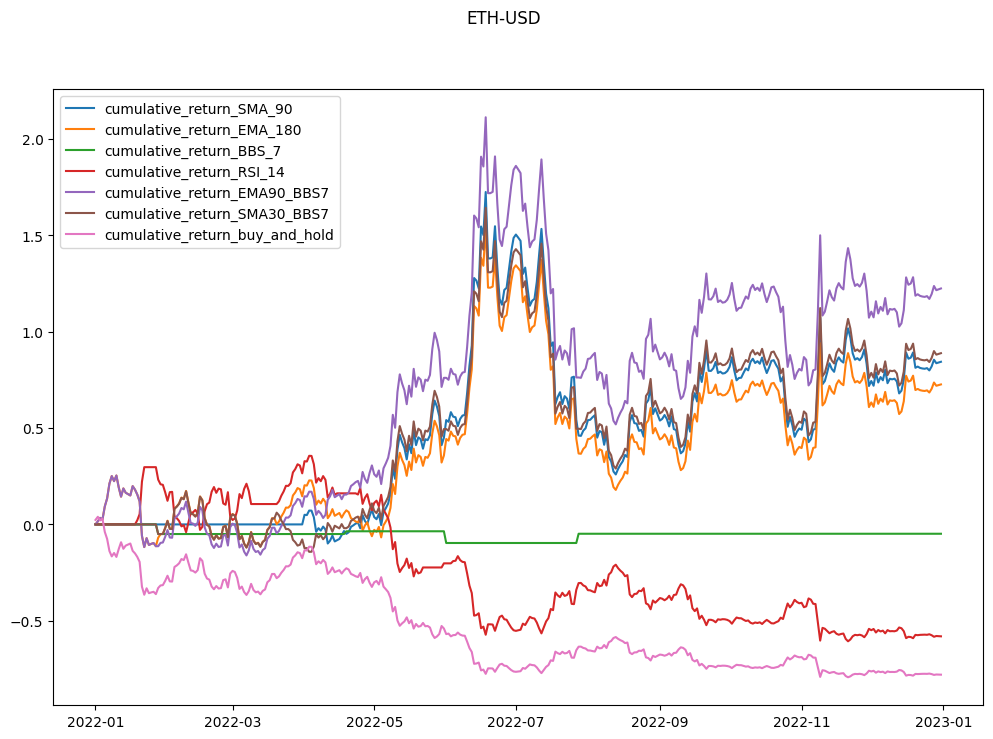

In [118]:
BEST_STRATEGIES = ['SMA_90', 'EMA_180', 'BBS_7', 'RSI_14', 'EMA90_BBS7', 'SMA30_BBS7', 'buy_and_hold']

nrows=1
ncols=1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    ax.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
# ax.plot(regression_baseline-1, label=f"{metric}_buy_and_hold")
plt.legend()
plt.suptitle(ROBUSTNESS_SET)
plt.show()

**Compare Sharpe Ratio**

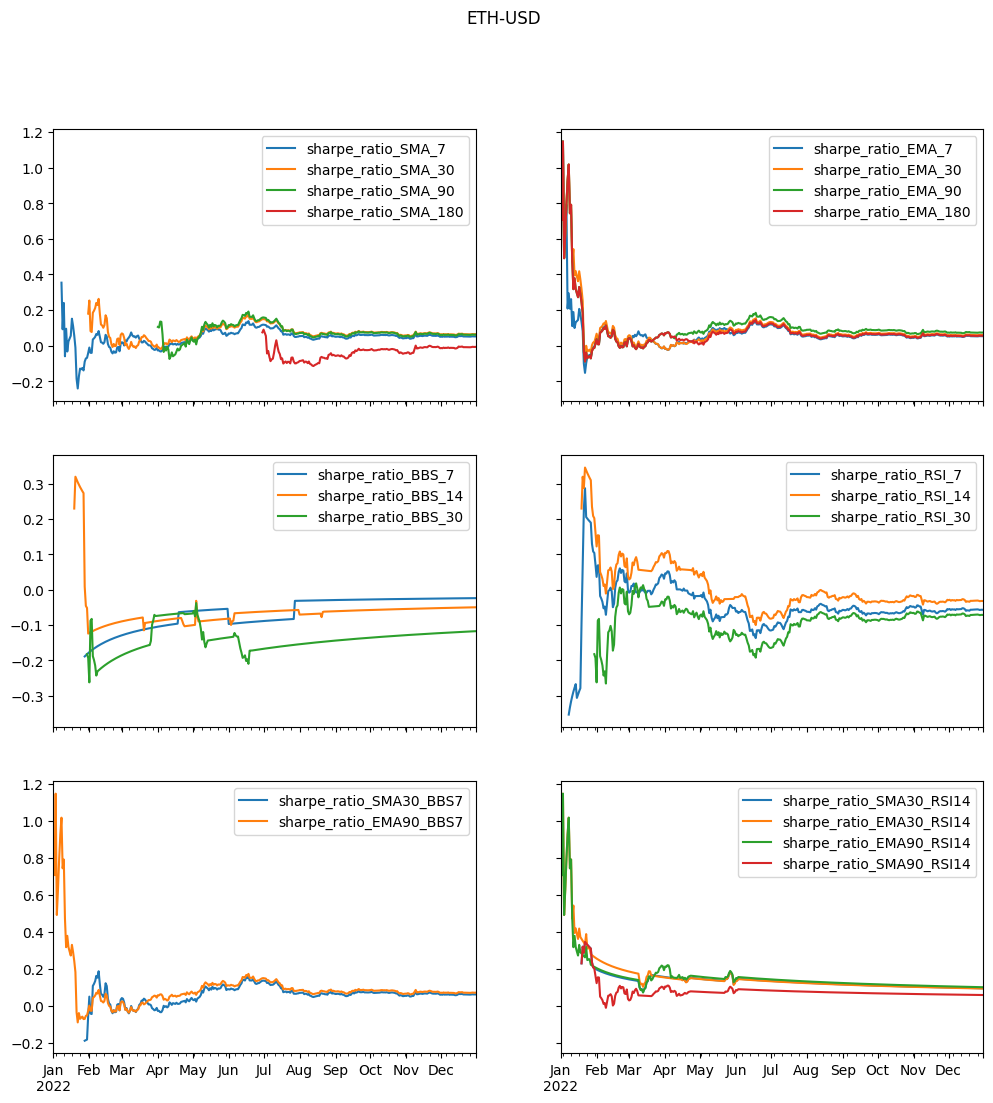

In [119]:
METRIC = 'sharpe_ratio'
STRATEGY_CATEGORIES = ['SMA', 'EMA', 'BBS', 'RSI', 'MA_BBS', 'MA_RSI']

nrows=3
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey='row', sharex=True)
for i, strategy in enumerate(STRATEGY_CATEGORIES):
    ax = axs[i//ncols][i%ncols]
    if strategy not in ['MA_BBS', 'MA_RSI']:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and col.split("_")[-2]==strategy]]
    else:
        df_plot = df_performance_metrics[[col for col in df_performance_metrics.columns if col.startswith(METRIC) and strategy.split("_")[-1] in col and 'MA' in col]]
    df_plot.plot(ax=ax)
plt.suptitle(ROBUSTNESS_SET)
plt.show()

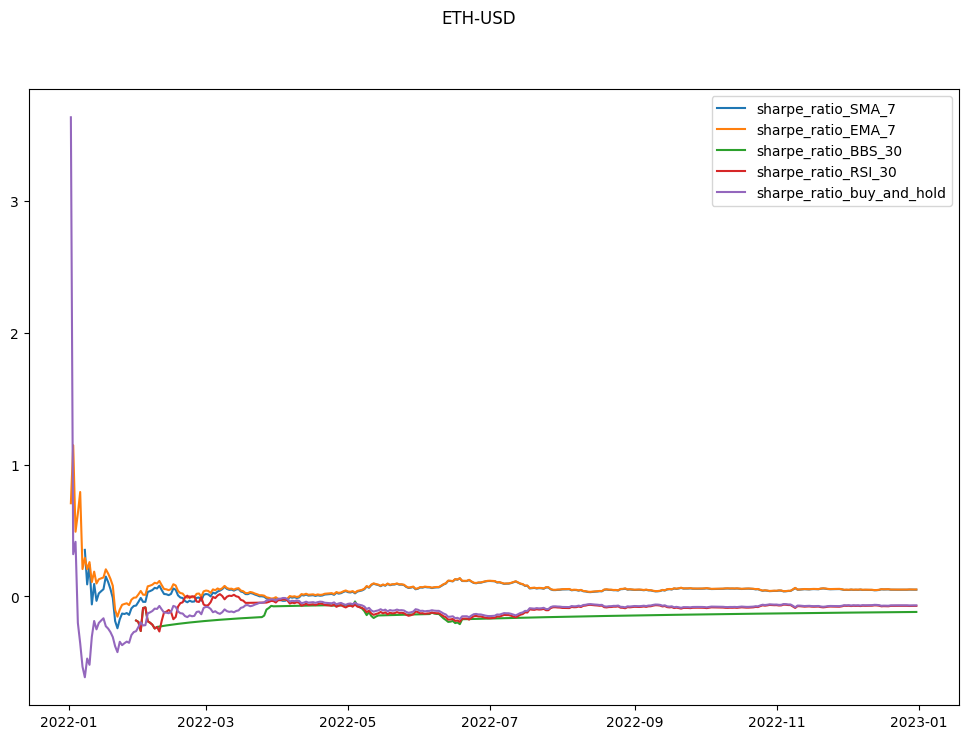

In [120]:
BEST_STRATEGIES = ['SMA_7', 'EMA_7', 'BBS_30', 'RSI_30', 'buy_and_hold']

nrows=1
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey='row', sharex=True)
for strategy in BEST_STRATEGIES:
    plt.plot(df_performance_metrics[f'{METRIC}_{strategy}'], label=f"{METRIC}_{strategy}")
plt.legend()
plt.suptitle(ROBUSTNESS_SET)
plt.show()